# Data Madness - Wallstreet Bets vs. The World

**Authors:**

Trevina Litchmore i6183835

Spriha Joshi i6180416

Tim Dick i6112326

## Introduction

In the month of January 2021 the Game Stop stock price elicited a large bump. This observation can be attributed to a manipulation scheme that was mostly driven by amateur investors and planned on the subreddit wallstreetbets of the social networking platform reddit.com. The hereby documented Data Madness project aimed to investigate the social dynamics behind this manipulation scheme. A ring-leader of the Gamestop stock price manipulation scheme is known by the pseudonym DeepFuckingValue (aka DFV)(https://www.boston.com/news/local-news/2021/02/18/keith-gill-roaring-kitty-gamestop-congress). The first question asked whether an actor's popularity in the wallstreetbets subreddit community correlates with the sudden Game Stop stock rise. The second question asked whether the social dynamics of the wallstreetbets subreddit discussion on GME were driven by a few popular actors or rather by the entire community. Lastly, the analysis aimed to identify other stocks that receive increasing attention from the wallstreetbets community.

### Stakeholders

Within the scope of the educational setting the primary stakeholders of this analysis are the authors themselves who aim to grow their data analysis skills. In particular, the goal of this assignment is to learn how to download, preprocess, explore and analyse realistic data sets. The secondary stakeholders are the author's peers who can learn from the project. A tertiary stakeholder is the Institute of Datascience in Maastricht which benefits from preparing its students for the data science job market. Outside the scope of the educational setting the primary stakeholders are the owners of stocks who loose their investments as a consequence of organized misconduct. Secondary stakeholders are legislators who can adjust rules and regulations of the financial market to account for this form of organized stock price manipulation. Lastly, a tertiary stakeholder is the platform Reddit.com which can learn to detect the planning of collective action that harms other people's finance. 

### Ethical Considerations

As this analysis is concerned with the social behaviour of real people it is worth considering its ethical aspects. One might argue that the users of the Reddit community are aware that their posts are submitted to public discussions that everyone can read or write to. Yet there is a difference between a human reading through some discussions and a rigorous analysis processing large numbers of posts. The insights gained from the analysis might surpass the expectations of the user who submits a post to the discussion forum. Yet, Reddit.com uses pseudonyms to conceil user's identity and prevent extraneous parties from identifying the real person behind a post. Apart from that, the here documented analysis confines itself to posts available for download and ignores those of users who have decided to delete their accounts in the meantime. With the exception of the user DFV who publicly declared his identity (https://www.boston.com/news/local-news/2021/02/18/keith-gill-roaring-kitty-gamestop-congress) the hereby executed analysis thus obeys the user's right to stay anonymous during the analysis.

In [85]:
! pip install networkx
! pip install statsmodels
! pip install psaw
! pip install praw
! pip install nltk
! pip install openpyxl
! pip install twython

In [86]:
import requests, matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from random import randint
import requests, json, time, datetime, requests.auth,re
import numpy as np
from dateutil.parser import parse
from datetime import date
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import praw
import os, sys
from psaw import PushshiftAPI
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist 
import nltk; nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from openpyxl.workbook import Workbook
import random as rd

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/trevinalitchmore/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Question 1: Who were the key players within the community ? And does their popularity correlate with the rise in the Gamestop stock price?

To answer this question, data was retrieved via the RedditAPI and also via PRAW, a wrapper for this API. The code below was used to retrieve top submissions that mentioned GME or Gamestop and saved the author, score,  and timestamp from the submission.

In [ ]:
#client_auth = requests.auth.HTTPBasicAuth('<Add client ID here>', '<Add client secret here>')
#post_data = {"grant_type": "password", "username": "<Add Reddit username here", "password": "<Add Reddit password here>"}
#headers={"Authorization": "bearer <Insert access token here>","User-Agent": "<Insert name of user-agent here>"}

##Function to search wallstreet bets submissions.
#def get_data(after,author,score,utc,continuing):
#    #Parameters you can find at https://www.reddit.com/dev/api
#    response = requests.get("https://oauth.reddit.com/r/wallstreetbets/search", headers=headers,
#                            params={"q": "GME OR gamestop", "limit": 100, "sort": 'top',"after":after})
#    response_j = response.content.decode("utf-8")
#    response_di = json.loads(response_j)
#    for i in range(100):
#        try:
#            author.append(response_di['data']['children'][i]['data']['author_fullname'])
#            score.append(response_di['data']['children'][i]['data']['score'])
#            utc.append(response_di['data']['children'][i]['data']['created'])
#            next = (response_di['data']['after'])
#        except:
#            continuing=False
#            break
#    return next,continuing

#author_list=[]
#score_list=[]
#created_list=[]
#next=''
#j=0
#continuing=True
#while continuing==True:
#    if j==0:
#        j=j+1
#        response = requests.get("https://oauth.reddit.com/r/wallstreetbets/search", headers=headers,
#                                params={"q": "GME OR gamestop", "limit": 100, "sort": "top"})
#        response_j = response.content.decode("utf-8")
#        response_d = json.loads(response_j)
#        for k in range(100):
#            try:
#                author_list.append(response_d['data']['children'][k]['data']['author_fullname'])
#                score_list.append(response_d['data']['children'][k]['data']['score'])
#                created_list.append(response_d['data']['children'][k]['data']['created'])
#                next = (response_d['data'][k]['after'])
#            except:
#                break
#        time.sleep(1)
#    else:
#        next,continuing=get_data(next,author_list,score_list,created_list,continuing)
#        time.sleep(1)


#print(len(created_list))
#data=np.empty([len(created_list),3],dtype=object)
#data[:,0]=author_list
#data[:,1]=score_list
#data[:,2]=created_list
#df_popularSub=pd.DataFrame(data,columns=['author','score','utc'])
#df_popularSub.to_csv('submissions.csv')

The script below was used to gather user data, namely the username as it appears on Reddit.

In [ ]:
#reddit=praw.Reddit(
#    client_id='<Add client id here>',
#    client_secret='<Add client secret here>',
#    user_agent='<Add user agent name here>',
#)

#user=praw.models.Redditor(reddit=reddit,fullname='t2_aqg7k')
#print(user.name)

To gather user submissions the script below was used.

In [ ]:
#client_auth = requests.auth.HTTPBasicAuth('<Add client ID here>', '<Add client secret here>')
#post_data = {"grant_type": "password", "username": "<Add Reddit username here", "password": "<Add Reddit password here>"}
#headers={"Authorization": "bearer <Insert access token here>","User-Agent": "<Insert name of user-agent here>"}

#def get_data(after,subreddit,score,utc,continuing):
#    response = requests.get("https://oauth.reddit.com/user/DeepFuckingValue/submitted", headers=headers,params={"limit":100,"t":"all","after":after})
#    response_j = response.content.decode("utf-8")
#    response_di = json.loads(response_j)
#    for i in range(100):
#        try:
#            score.append(response_di['data']['children'][i]['data']['score'])
#            utc.append(response_di['data']['children'][i]['data']['created'])
#            subreddit.append(response_di['data']['children'][i]['data']['subreddit'])
#            next = (response_di['data']['after'])
#        except:
#            continuing=False
#            break
#    return next,continuing

#score_list=[]
#created_list=[]
#subreddit_list=[]
#next=''
#j=0
#continuing=True
#while continuing==True:
#    if j==0:
#        j=j+1
#        response = requests.get("https://oauth.reddit.com/user/DeepFuckingValue/submitted", headers=headers,params={"limit":100,"t":"all"})
#        response_j = response.content.decode("utf-8")
#        response_d = json.loads(response_j)
#        for k in range(100):
#            try:
#                score_list.append(response_d['data']['children'][k]['data']['score'])
#                created_list.append(response_d['data']['children'][k]['data']['created'])
#                subreddit_list.append(response_d['data']['children'][k]['data']['subreddit'])
#                next = (response_d['data'][k]['after'])
#            except:
#                break
#        time.sleep(1)
#    else:
#        next,continuing=get_data(next,subreddit_list,score_list,created_list,continuing)
#        time.sleep(1)

#print(len(created_list))
#data=np.empty([len(created_list),3],dtype=object)
#data[:,0]=score_list
#data[:,1]=created_list
#data[:,2]=subreddit_list
#df_popularSub=pd.DataFrame(data,columns=['score','utc','subreddit'])
#df_popularSub.to_csv('DFV.csv')

First, the top submissions on the wallstreetbets subreddit was downloaded from the Reddit API that discussed Gamestop (GME) and organized in a dataframe. Only top submissions were considered because these are the posts that received the largest share of upvotes and we will use these upvotes as a way to identify these influencers and as a proxy for popularity.

In [5]:
topSubs=pd.read_csv('submissions_edit.csv',delimiter=';')
topSubs.head()

,author,score,utc
0,t2_49l8qytq,275811,1.611897e+09
1,t2_49l8qytq,275808,1.611897e+09
2,t2_49l8qytq,248255,1.611983e+09
3,t2_7xln8iwn,220502,1.611871e+09
4,t2_49l8qytq,213034,1.613798e+09


The timeframe was then limited to a time window spanning from 1 June 2019 (when DFV first invested in the GME) until 28 January 2021 (when the Robinhood trading platform halted buying GME stocks due to the unusually large volume of trades originating from the platform). 

In [6]:
topSubs=topSubs[topSubs['utc']>=1559246400]
topSubs=topSubs[topSubs['utc']<=1611806400]
topSubs=topSubs.reset_index(drop=True)

Descriptive statistics for the scores of the submissions from that time period. 

In [7]:
topSubs['score'].describe()

count        34.000000
mean      63740.470588
std       25754.935464
min       33182.000000
25%       39949.500000
50%       59570.000000
75%       82612.000000
max      133756.000000
Name: score, dtype: float64

Most popular users, are those with the most frequently occuring and highest scored posts. We will take the mode to see which authors appear most frequently.

In [8]:
topSubs['author'].describe()

count              34
unique             30
top       t2_49l8qytq
freq                5
Name: author, dtype: object

Here user t2_4918qytq (aka DFV) has the most highest scoring submissions in this time frame. Let's remove this user name to see who would be the next most popular user.

In [9]:
removeMode=topSubs[topSubs['author']!='t2_49l8qytq']
removeMode=removeMode.reset_index(drop=True)

In [10]:
removeMode['author'].describe()

count           29
unique          29
top       t2_xd2id
freq             1
Name: author, dtype: object

**Discussion**: It is clear that DFV is the most influential redditor on the wallstreetbets subreddit. Five of his posts were among the top 29 posts from 1 June 2019 to 28 January 2021 that discussed the Gamestop stock. In second place were 29 other users who managed to get one post on this list. Since it is not clear if these individuals are actually influential or were just lucky to make it to the top of the list, only DFV will be analyzed.  

## **Identifying Popularity Trends**

To ensure that the data is representative of DFV during the development of the GameStop stock squeeze phenomenon, the submissions analyzed were restricted to 1 June 2019 and 28 January 2021.

In [11]:
#Method to clean the data
def data_clean(topSubs):
    cleanSubs=topSubs[topSubs['utc']>=1559246400]
    cleanSubs=cleanSubs[cleanSubs['utc']<=1611806400]
    cleanSubs=cleanSubs[cleanSubs['subreddit']=='wallstreetbets']
    cleanSubs=cleanSubs.reset_index(drop=True)
    return cleanSubs

**Analysis of DFV's Submission Scores**

In [12]:
dfv=pd.read_csv('DFV.csv',delimiter=';')
dfv=data_clean(dfv)
dfv.head()

,score,utc,subreddit
0,133760,1.611724e+09,wallstreetbets
1,81556,1.611638e+09,wallstreetbets
2,90816,1.611379e+09,wallstreetbets
3,38820,1.611119e+09,wallstreetbets
4,23091,1.610687e+09,wallstreetbets


In [13]:
dfv['score'].describe()

count        44.000000
mean      12714.863636
std       27111.871447
min          21.000000
25%          62.250000
50%        3389.500000
75%        9095.000000
max      133760.000000
Name: score, dtype: float64

<AxesSubplot:xlabel='score', ylabel='Count'>

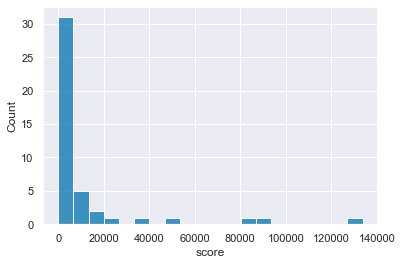

In [14]:
sns.set_theme(style='darkgrid',palette='colorblind')
sns.histplot(data=dfv,x='score',bins=20)

<AxesSubplot:ylabel='score'>

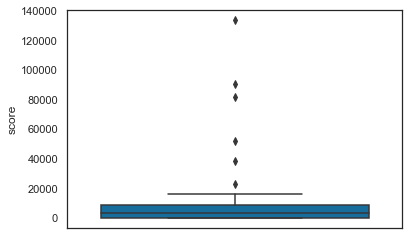

In [15]:
sns.set_theme(style='white',palette='colorblind')
sns.boxplot(data=dfv,y='score')

From the data, the scores that DFV earned for his submissions is heavily skewed to the left. Since, there are 20 bins in the histogram, most of his submissions on wallstreet bets received scores (or upvotes) that were between 21 and 9095. The larger scores, those greater than 20,000 were outliers when looking at his overall submission history. When looking at the median score, his submissions received much less than 20,000 upvotes (around 3389). Thus, his posts usually do not attract such extreme popularity as we see at the higher end of the range at over 133,760 upvotes.

## DFV's Popularity Vs. GME Stock Price

Now, we shall compare the performance of the stock price to the trend in DFV's popularity over time.

In [16]:
gsp=pd.read_csv('GME_Stock_History.csv')
gsp.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2/4/2021,91.190000,91.500000,53.33,53.50,61903600,0.0,0
1,2/3/2021,112.010000,113.400000,85.25,92.41,42698500,0.0,0
2,2/2/2021,140.760000,158.000000,74.22,90.00,78183100,0.0,0
3,2/1/2021,316.560000,322.000000,212.00,225.00,36655400,0.0,0
4,1/29/2021,379.709992,413.980011,250.00,325.00,50397132,0.0,0


In [17]:
type(gsp['Date'][0])

str

First, let's prepare the stock price data. We will start with converting the date column into a date time type. It is currently a string data type.

In [18]:
for i in range(gsp.shape[0]):
    a=gsp['Date'][i].split('/')
    gsp.iat[i,0]=date(int(a[2]),int(a[0]),int(a[1])).isoformat()

Then, we will restrict the date so that it goes from 1 June 2019 to 28 Jan 2021.

In [19]:
gsp_reduce1=gsp[gsp['Date']>='2019-06-01']
gsp=gsp_reduce1[gsp['Date']<='2021-01-28']
gsp1=gsp.sort_values(by='Date')
gsp1=gsp1.reset_index(drop=True)

/Users/trevinalitchmore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Next we shall convert the utc time stamp to date time to plot the scored submissions together with the Gameshop stock price.

In [20]:
def utc_to_dt(df1):
    df_time=[pd.to_datetime(df1['utc'][i],unit='s').isoformat() for i in range(df1.shape[0])]
    times=[]
    for j in range(df1.shape[0]):
        time_parsed=parse(df_time[j])
        times.append(date(time_parsed.year,time_parsed.month,time_parsed.day).isoformat())
    df1['utc']=times
    return df1

In [21]:
dfv=utc_to_dt(dfv)
dfv=dfv.sort_values(by='utc')
dfv=dfv.reset_index(drop=True)

Now, we shall ensure that for each time point there is a corresponding submission and a stock price listed for comparison.

In [22]:
def mask_maker(mask_list,series):
    #Creates a mask based on the presence of items in a series. In this case, it is used to ensure the dates that are  
    #in the list are the same as those in the series.
    mask=[]
    for i in range(series.shape[0]):
        if series[i] in mask_list:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [23]:
#DFV
dfv_dates=dfv['utc'].to_list()
gsp1_mask=mask_maker(dfv_dates,gsp1['Date'])
gsp1_dfv=gsp1[gsp1_mask]
gsp1_dfv=gsp1_dfv.reset_index(drop=True)
gsp1_dates=gsp1_dfv['Date'].to_list()
dfv_mask=mask_maker(gsp1_dates,dfv['utc'])
dfv_gsp1=dfv[dfv_mask]
dfv_gsp1=dfv_gsp1.reset_index(drop=True)
#We then add the price as an extra column to the influencer score DataFrame.
dfv_gsp1['price']=gsp1_dfv['Close']

Then, we compute the logarithm of the stock prices and submission scores in order to graphically compare their trends.

In [24]:
dfv_gsp1['price']=np.log(dfv_gsp1['price'])
dfv_gsp1['score']=np.log(dfv_gsp1['score'])

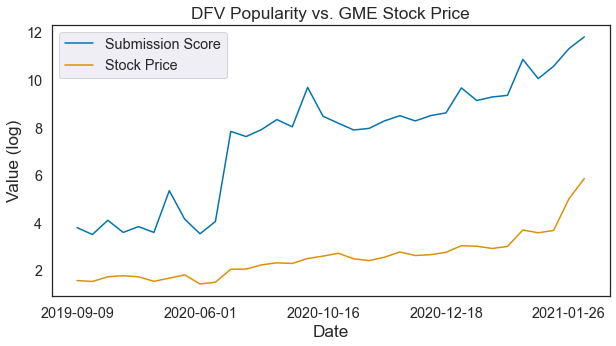

In [25]:
fig,ax=plt.subplots(figsize=(10,5))

sns.set_theme(style='darkgrid',palette='colorblind')
sns.lineplot(x='utc',y='score',data=dfv_gsp1)
sns.lineplot(x='utc',y='price',data=dfv_gsp1)
ax.set_xticks(range(0,33,8))
ax.tick_params(labelsize='large')
plt.ylabel('Value (log)',fontsize='x-large')
plt.xlabel('Date',fontsize='x-large')
plt.title('DFV Popularity vs. GME Stock Price',fontsize='x-large')
ax.legend(['Submission Score','Stock Price'],fontsize='large')

In the graphs below we plot both DFV's popularity over time as well as the price of the GME stock to give the above graph more context.

Text(0.5, 1.0, 'DFV Popularity Trend')

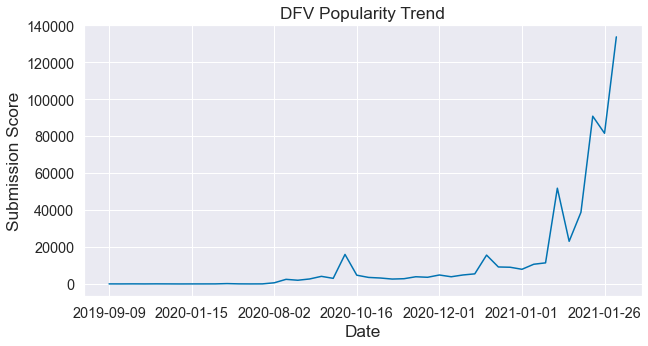

In [26]:
fig1,ax1=plt.subplots(figsize=(10,5))
sns.set_theme(style='darkgrid',palette='colorblind')
sns.lineplot(x='utc',y='score',data=dfv)
ax1.set_xticks(range(0,44,7))
ax1.tick_params(labelsize='large')
plt.ylabel('Submission Score',fontsize='x-large')
plt.xlabel('Date',fontsize='x-large')
plt.title('DFV Popularity Trend',fontsize='x-large')

Text(0.5, 1.0, 'GME Stock Price Trend')

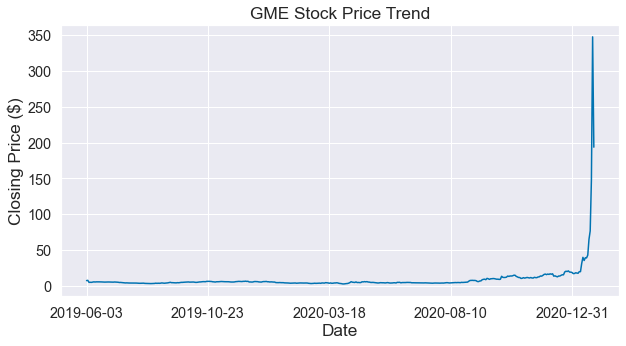

In [27]:
fig2,ax2=plt.subplots(figsize=(10,5))
sns.set_theme(style='darkgrid',palette='colorblind')
sns.lineplot(x='Date',y='Close',data=gsp1)
ax2.set_xticks(range(0,419,100))
ax2.tick_params(labelsize='large')
plt.ylabel('Closing Price ($)',fontsize='x-large')
plt.xlabel('Date',fontsize='x-large')
plt.title('GME Stock Price Trend',fontsize='x-large')

The plot that compares the increase in DFV's popularity with the rise in stock price, it appears that DFV's popularity is somewhat mirroring the increase in the stock price from September 2019 onwards. There are spikes and falls in his popularity from 2019 until 2020 that are not captured in the general movement of the stock price. Looking closer at the data,analyzing the change in price of the stock as well as the change in his popularity on the platform (using submission scores/upvotes as a proxy) he begins to pick up some momentum from around that time period onwards. However, DFV experiences exponential growth in his popularity during the month of January, which is also arond the same time in which the price of the GME stock also experienced exponential growth.

More analysis would be needed to determine if he was the main factor behind the rapid increase in the stock price as there are also other external factors that would need to be accounted for as well. Additionally, his increase in popularity could also be due to the fact that he made quite a bit of money (reportedly millions of dollars) during the Gamestop squeeze. On a subreddit that frequently has users posting their gains, perhaps his popularity was fueled by the fact he had made a large sum of money by investing in a business that the market expected to soon fail.

## Testing the Strength of the Relationship Between DFV's Popularity and the GME Stock Price

To test the hypothesis that the popularity of DFV is closely tied to the performance of the GME stock, we will use a linear regression model.

First, we will check to see if there is any correlation between the two variables. Given that the range is quite large between the two values, their logarithmic values have been used for this model.

In [28]:
regress_dfv=pd.DataFrame()
regress_dfv['score']=dfv_gsp1['score']
regress_dfv['price']=dfv_gsp1['price']

In [29]:
regress_dfv.corr()

,score,price
score,1.000000,0.853243
price,0.853243,1.000000


In [30]:
dfv_gsp1_ols=sm.ols(formula='price ~ score',data=regress_dfv).fit()
dfv_gsp1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     85.66
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           1.45e-10
Time:                        05:11:11   Log-Likelihood:                -24.523
No. Observations:                  34   AIC:                             53.05
Df Residuals:                      32   BIC:                             56.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1209      0.277      0.436      0.665      -0.443       0.685
score          0.3235      0.035      9.255      0.000       0.252       0.395
==============================================================================
Omnibus:                       26.582   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.995
Skew:                           1.857   Prob(JB):                     3.11e-12
Kurtosis:                       7.859   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Linear Regression Model with Logarithmic Values')

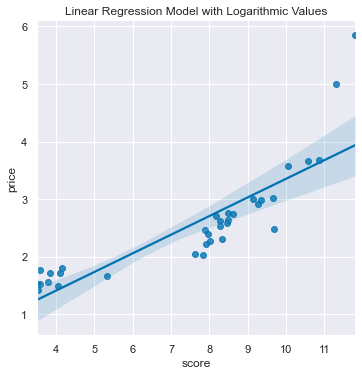

In [31]:
sns.lmplot(x='score',y='price',data=regress_dfv,scatter=True,fit_reg=True)
plt.title('Linear Regression Model with Logarithmic Values')

In this linear regression model, the popularity of DFV explains 72.8% of the variablity in the stock price with the logarithmically adjusted values. Also, it appears to be a statistically relevant association as the p-value is 0. Thus, DFV's popularity indeed has a strong relationship to the stock price of GME. This is not entirely surprising, as he has discussed this investment move on the subreddit and his strategy has clearly paid off in terms of the gains he saw with this stock.

**What's next?**

Given that DFV's popularity skyrocketed partly due to the sucess of the GME stock squeeze, who else may have tried to latch onto this success? And what happened to DFV after the news broke? 

Let's investigate who are among the most recent crop of influencers by mining the top submissions on GME and expand the time frame to March 21st...

In [32]:
topSubs=pd.read_csv('submissions_edit.csv',delimiter=';')

In [33]:
topSubs=topSubs[topSubs['utc']>=1559246400]
topSubs=topSubs[topSubs['utc']<=1616296460]
topSubs=topSubs.reset_index(drop=True)

In [34]:
topSubs['author'].describe().freq

15

Once again user t2_4918qytq (aka DFV) is the most popular user in the subreddit, even two months later. Let's remove this user name (and put it into a list for an eventual visualization)to see who would be the next most popular user.

In [35]:
topUser=[]
frequency=[]
topUser.append('DFV')
frequency.append(topSubs['author'].describe().freq)

In [36]:
removeMode=topSubs[topSubs['author']!='t2_49l8qytq']
removeMode=removeMode.reset_index(drop=True)

In [37]:
removeMode['author'].describe()

count          224
unique         216
top       t2_bd6q5
freq             5
Name: author, dtype: object

Another user has emerged as a possible influencer in only 2 months, t2_bd6q5, (aka OPINION_IS_UNPOPULAR). Once again let's remove this user name (and put it into a list for an eventual visualization)to see who would be the next most popular user.

In [38]:
topUser.append('OPINION_IS_UNPOPULAR')
frequency.append(removeMode['author'].describe().freq)

In [39]:
removeMode=removeMode[removeMode['author']!='t2_bd6q5']
removeMode=removeMode.reset_index(drop=True)

In [40]:
removeMode['author'].describe()

count             219
unique            215
top       t2_106nm59t
freq                2
Name: author, dtype: object

Since we will stop at 2 posts, we will see who else has two posts.

In [41]:
removeMode['author'].mode()

0    t2_106nm59t
1       t2_7xyxw
2       t2_aqg7k
3       t2_yesu4
dtype: object

t2_7xyxw (aka PaTTeRN_iNTeGRiTy),t2_aqg7k (aka CriticDanger),t2_106nm59t(aka Tsukune_Surprise) and t2_yesu4( aka aBetterNation) have emerged as other potentially influencial users having a total of 2 of the top posts in the subreddit.

In [42]:
topUser.append('PaTTeRN_iNTeGRiTy')
topUser.append('CriticDanger')
topUser.append('Tsukune_Surprise')
topUser.append('aBetterNation')
frequency.append(2)
frequency.append(2)
frequency.append(2)
frequency.append(2)

In [43]:
popUsers=pd.DataFrame()
popUsers['user']=topUser
popUsers['frequency']=frequency

Text(0.5, 1.0, 'Number of Top Posts per Influencer')

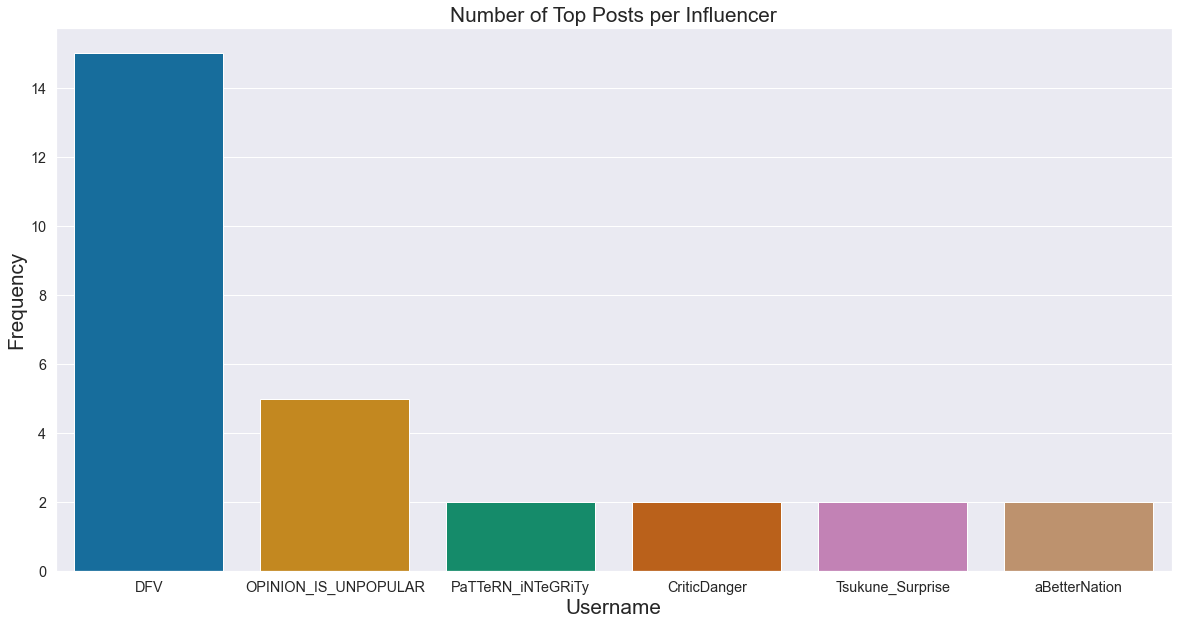

In [44]:
fig,ax=plt.subplots(figsize=(20,10))
sns.set_theme(style='darkgrid',palette='colorblind')
sns.barplot(x='user',y='frequency',data=popUsers)
ax.tick_params(labelsize='large')
plt.ylabel('Frequency',fontsize='xx-large')
plt.xlabel('Username',fontsize='xx-large')
plt.title('Number of Top Posts per Influencer',fontsize='xx-large')

In the span of approximately two months, the number of influencers has expanded to 6. DFV is still the most influential however. After 28 Jan 2021, he added 10 more posts to his total. Even if he may not be the sole influence on the price of the GME stock increase, he has clearly inspired a following and is shaping the discourse on the subreddit.

# Question 2 - Did a few key players influence a large crowd of followers or was social influence more evenly spread within the community ?

In [46]:
#from google.colab import drive
#drive.mount('/content/drive')

In [73]:
## Configuration
after_date = '23/12/2020'; before_date = '25/12/2020'; subreddit='wallstreetbets'; query = 'GME'; size = 500
drive_path = 'reddit posts/'
def make_path(drive_path, size, subreddit, query, after_date, before_date):
  return drive_path + f"<={size} reddit submissions from {subreddit} for query {query} after {after_date.replace('/','-')} before {before_date.replace('/','-')}/"
path = make_path(drive_path, size, subreddit, query, after_date, before_date)

In order to answer the three research questions discussions containing the GME keyword were scraped from reddit. Initially, the discussions of one day per week (Friday) were downloaded for 3 months surrounding the stock price bump (13-11-2020 until 12-2-2021). The first research question was answered by analyzing discussion on a more fine-grained temporal resolution to improve the predictive power of the model. For this purpose the 7 days in between 19-12-2020 and 25-12-2020 were selected since their discussions showed highest participation by the community. The data was downloaded by the authors themselves via the pushshift API (https://github.com/pushshift/api).

In [74]:
#os.makedirs(os.path.dirname(path), exist_ok=True)

In [75]:
def search_submissions(after, before, subreddit, query, fields, size):
  after  = str((int)(time.mktime(datetime.datetime.strptime(after , "%d/%m/%Y").timetuple()))) 
  before = str((int)(time.mktime(datetime.datetime.strptime(before, "%d/%m/%Y").timetuple())))
  result = requests.get("https://api.pushshift.io/reddit/search/submission/?q="+query+"&subreddit="+subreddit+"&before="+before+"&after="+after+"&size="+str(size)+"&fields="+','.join(fields))
  if not result.status_code==200:
    print('Unable to perform request with status code: ' + str(result.status_code))
    return pd.DataFrame(columns=fields)
  else: 
    return pd.DataFrame(json.loads(result.text)['data'])
  
def clean_data_frame(df):
  return df[(df['author'] != '[deleted]') & (df['author'] != 'AutoModerator')].copy()

In [77]:
submission_fields = ['author','author_fullname','created_utc','id','removed_by_category','score','selftext','upvote_ratio']
submissions_df = search_submissions(after=after_date, before=before_date, subreddit=subreddit, query=query, fields=submission_fields, size=size)
submissions_df = clean_data_frame(submissions_df)
submissions_df.to_excel(path+'Submissions.xlsx')
submissions_df.head()

,author,author_fullname,created_utc,id,score,selftext,upvote_ratio,removed_by_category
0,TexasExPat1,t2_4gdm3da2,1608678089,kigbh0,1,,1.0,NaN
1,DBroker1997,t2_5t1c5yju,1608678931,kiglfi,1,,1.0,NaN
2,badgerbacon6,t2_cwbr6,1608679090,kign9p,1,,1.0,NaN
3,KYJELLYTIME69,t2_87buwj2p,1608679120,kignn7,1,Ok so I was in the process of writing a long D...,1.0,NaN
4,wallstreetdaddy,t2_8prdwfaa,1608680106,kigyvo,1,,1.0,NaN


In [78]:
def fetch_comments(submission_id, fields):
  result = requests.get("https://api.pushshift.io/reddit/submission/comment_ids/"+submission_id)
  if not result.status_code==200:
    print('Unable to perform request with status code: ' + str(result.status_code))
    return pd.DataFrame(columns=fields)
  else:
    comment_ids = json.loads(result.text)['data']
    result = requests.get("https://api.pushshift.io/reddit/comment/search?ids="+','.join(comment_ids)+"&fields="+','.join(fields)+"&size="+str(min(len(comment_ids),500)))
    if not result.status_code==200:
      print('Unable to perform request with status code: ' + str(result.status_code))
      return pd.DataFrame(columns=fields)
    else:
      result = json.loads(result.text)['data']
      if result == []: return pd.DataFrame(columns=fields)
      else: return pd.DataFrame(result)

In [80]:
comment_fields = ['author','author_fullname','body','created_utc','id','link_id','score','parent_id','subreddit','subreddit_id']
comments_df = fetch_comments(submission_id=submissions_df.iloc[2]['id'], fields=comment_fields)
comments_df.head()

,author,body,created_utc,id,link_id,parent_id,score,subreddit,subreddit_id,author_fullname
0,[deleted],[deleted],1608679706,ggqqslc,t3_kign9p,t3_kign9p,2,wallstreetbets,t5_2th52,NaN
1,IDontBeleiveImOnFIre,GME Bears are pooping their pants at how poor ...,1608679738,ggqqumg,t3_kign9p,t3_kign9p,9,wallstreetbets,t5_2th52,t2_v9bi0f8
2,Rrrrandle,2012? More like 1992.,1608679753,ggqqvmc,t3_kign9p,t3_kign9p,4,wallstreetbets,t5_2th52,t2_5xbrca8f
3,WSBVoteBot,**If this is [spam](https://www.reddit.com/r/w...,1608680697,ggqskif,t3_kign9p,t3_kign9p,1,wallstreetbets,t5_2th52,t2_26k75u4f
4,dc2696,Position: 450 @$15\n\nI've done my part\n\nHav...,1608681319,ggqtodz,t3_kign9p,t3_kign9p,6,wallstreetbets,t5_2th52,t2_z7h9d


## Methods

### Question:  How large is the impact of the most popular wallstreetbets subreddit actors on the remaining community when it comes to discussions on the GME stock price ?

To answer this question a Markov Model for opinion dynamics proposed by Diao et al. (2014) was implemented. This model relies on a social network representation $G(V,E)$ where actors are represented by nodes $v \in V$ and their interactions by arcs $e \in E$. Note that interactions can be directed and multiple arcs between the same pair of nodes are possible. For a given day $t$ the model describes an actor's verbal action towards a certain topic by a state $X \in \{'supporting','opposing'\}$. Here, verbal action was determined by classiying that actor's sentiment for all their posts during day $t$ with the help of natural language tool kit (https://www.nltk.org). The method maintains a variable $Odd_S \in (0,\infty)$ which models the person's latent opinion towards supporting behaviour. $Odd_S$ is updated at every time step by randomly sampling $N_{px}$ persuaders from the set of nodes $V$. $N_{pS}$ is the number of persuaders who elicited a positive sentiment at day $t$ and vice versa for $N_{pO}$. The social influence of a persuader on a target individual is then scaled by their proximity in the social network (shortest path between them). Influences of supportive and opposing persuaders are are then used to update the target individual's $Odd_S$ and hence their predicted verbal action for the next time point $t+1$. Values of $Odd_S$ in the interval $(0,0.5)$ predict an actor's verbal behaviour to be opposing while values above $0.5$ predict supportive behaviour. Here, a large part of the community elicited neutral sentiment and hence Diao et al.'s model was adjusted to predict neutral behaviour when $Odd_S$ was within a small margin around 0.5 (detailed below). 
The model can thus be used to predict the sentiment of each actor towards the discussions on the GME subreddit. As a baseline a random model was used that would predict arbitrary actions. Two experimental conditions were compared, one of which included the most popular actors and one which excluded them. Popularity was determined by a node's degree.   

References:
 * Diao, S. M., Liu, Y., Zeng, Q. A., Luo, G. X., & Xiong, F. (2014). A novel opinion dynamics model based on expanded observation ranges and individuals’ social influences in social networks. Physica A: Statistical Mechanics and its Applications, 415, 220-228.

In [81]:
def update_user_graph(submission, comments_df, g):
  '''For each comment an arc is drawn from the author of the submission to the author of the comment. 
  Within the comments, consider commenter A and commenter B such that B comments on A. Then the author an arc is drawn from author of A to author of B.'''
  comments_df['parent_id'] = comments_df['parent_id'].map(lambda x: x[3:])
    
  for c, comment in comments_df.iterrows():
    # Add edge from submission author to each commenter
    g.add_edge(submission['author'], comment['author'])
    
    # Optionally add edges within commenters
    current_parent_id = comment['parent_id']
    while not current_parent_id == submission['id']:
      parent_df = comments_df[comments_df['id'] == current_parent_id]
      if not len(parent_df) == 1: 
        print(f"there are {len(parent_df)} parents with id {current_parent_id} for comment with id {comment.id} on submission with id {submission.id}")
        break
      else:
        parent = parent_df.iloc[0]
        g.add_edge(parent['author'], comment['author'])
        current_parent_id = parent['parent_id']   

In [82]:
g = nx.MultiDiGraph()
for s in range(len(submissions_df)):
  if s % 10 == 0: print(f"fetching comments for submission {s}")
  comments_df = fetch_comments(submission_id=submissions_df.iloc[s]['id'], fields=comment_fields)
  comments_df = comments_df.applymap(lambda x: x.encode('unicode_escape').decode('utf-8') if isinstance(x, str) else x)
  comments_df.to_excel(path + 'Comments on submission ' + str(submissions_df.iloc[s]['id']) + '.xlsx')
  update_user_graph(submissions_df.iloc[s].copy(), clean_data_frame(comments_df), g)

nx.write_gpickle(g, path+'Network.pickle')

fetching comments for submission 0
fetching comments for submission 10
there are 0 parents with id ggrg1pc for comment with id ggrgicm on submission with id kiht0p
there are 0 parents with id ggrg1pc for comment with id ggrgk58 on submission with id kiht0p
fetching comments for submission 20
there are 0 parents with id ggtjijp for comment with id ggtsvmr on submission with id kil4wu
there are 0 parents with id ggtx738 for comment with id ggtxbaf on submission with id kil4wu
there are 0 parents with id ggu1jqh for comment with id ggu1qzz on submission with id kil4wu
there are 0 parents with id ggu1jqh for comment with id ggu21z2 on submission with id kil4wu
fetching comments for submission 30
fetching comments for submission 40
fetching comments for submission 50
fetching comments for submission 60
fetching comments for submission 70
fetching comments for submission 80
fetching comments for submission 90


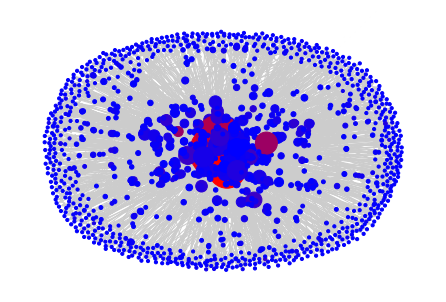

In [83]:
g = nx.read_gpickle(path + 'Network.pickle')
d_in = dict(g.in_degree()); max_in = max(d_in.values())
d_out = dict(g.out_degree())
nx.draw(g, edge_color=(0.8,0.8,0.8), nodelist=list(d_in.keys()), node_size=[v*5+10 for v in d_out.values()], node_color=[(v/max_in,0, 1 -v/max_in) for v in d_in.values()])
plt.savefig(path+'Network.png')

In [87]:
def compute_received_social_influence(g, N_p_o, N_p_s, individual_i_name, max_distance=5, min_degree_for_tabu=10^9, use_target=True):
  '''Computes the social influence on individual i. The value x in (A,B) is the orientation of an individual\'s outer actions. The persuaders in d_i and influences are assumed to be the same.
  Inputs:
    g: nx.MultiDiGraph representing the social network.
    N_p_o, N_p_s: int upper bound for the number of opposing and supporting persuaders.
    individual_i_name: str the name of the receiving individual.
    max_distance: int the maximum distance of persuaders from individual i
    min_degree_for_tabu: int indicating the minimum degree a node needs to have in order to be not selected as persuader.
    use_target: bool indicating whether a target individual shoudl persuade itself.
  Outputs:
    SI_i: float indicating the overall social influence received by individual i to engage in the action.'''
  tabu_names = set()
  for name, degree in dict(g.degree).items():
    if degree >= min_degree_for_tabu: tabu_names.add(name)
  supporting_names, opposing_names = search_random_persuaders(g=g, N_p_o=N_p_o, N_p_s=N_p_s, target_name=individual_i_name, max_distance=max_distance, tabu_names=tabu_names, use_target=use_target)
  
  supporting_influences = compute_eliciting_social_influence(g=g, persuader_names=supporting_names)
  supporting_distances = get_shortest_distances(g=g, persuader_names=supporting_names, target_individual_name=individual_i_name)
  SI_i_s = (N_p_s ** 0.5) * np.sum([supporting_influences[name_j] / ((supporting_distances[name_j]+1) ** 2) for name_j in supporting_influences.keys()])

  opposing_influences = compute_eliciting_social_influence(g=g, persuader_names=opposing_names)
  opposing_distances = get_shortest_distances(g=g, persuader_names=opposing_names, target_individual_name=individual_i_name)
  SI_i_o = (N_p_s ** 0.5) * np.sum([opposing_influences[name_j] / ((opposing_distances[name_j]+1) ** 2) for name_j in opposing_influences.keys()])
  
  return SI_i_s, SI_i_o

def compute_eliciting_social_influence(g, persuader_names):
  '''Computes the social influence each individual elicits by taking the square root of their out degree and multiplying it with -1, 0 or 1 depending on whether they act opposing, neutral or supporting, respectively.
  Inputs:
    g: networkx.MultiDiGraph for the social network o finterest.
    persuader_names: [str] collecting the names of people whose influence needs to be calculated.
  Outputs:
    social_influences: dict(str, float) providing the elicited social influence for each persuader.'''
  social_influences = dict.fromkeys(persuader_names)
  for persuader_name in persuader_names:
    social_influences[persuader_name] = g.out_degree(persuader_name) ** 0.5

  return social_influences

def update_odd_A(odd_A_n, SI_A_n, SI_B_n):
  '''Computes the odds for action A at time point n+1 for a given individual.
  Inputs:
    odd_A_n: float indicating the odds for action A of the given individual at time point n.
    SI_A_n, SI_B_n: float the social influence excerted on the given individual to perform action A or B at time n.
  Outputs:
    odd_A_n_plus_1: float indicating the odds for action A at time point n+1.'''
  numerator = 1 + SI_A_n / (SI_A_n + SI_B_n + 1e-5); denominator = 1 + SI_B_n / (SI_A_n + SI_B_n + 1e-5)
  odd_A_n_plus_1 = odd_A_n *  numerator / denominator
  return odd_A_n_plus_1

def update_influence_j(inf_j_n, colleague_influences_n, d_i, d_i_j, delta=1e-3):
  '''Updates the influence that person j has assuming that belongs to a group of persuaders who successfully influenced a target individual.
  Inputs: 
    inj_j_n: float the influence that individual j has at time point n.
    colleague_influences_n: [float] the influences that the other persuadors have on the affected individual at time n.
    d_i: [float] the distances between affected individual i and the here considered persuaders. Indexing is assumes to be synchronous with colleague_influences_n.
    d_i_j: float the distance between persuader j and affected individual i at time n (also contained in d_i).  
    delta: float an update rate
  Outputs:
    inf_j_n_plus_1: float the new social influence of individual j.'''
  numerator = inf_j_n / (d_i_j**2)
  denominator = np.sum([colleague_influences[k] / (d_i[k]**2) for k in range(len(d_i))])
  inj_j_n_plus_1 = inj_j_n + delta * numerator / denominator

def get_shortest_distances(g, persuader_names, target_individual_name, default_distance=5):
  '''Gets the shortest distances between persuaders and target individual in graph G.'''
  di = dict.fromkeys(persuader_names)
  for persuader_name in persuader_names:
    try:
      di[persuader_name] = nx.shortest_path_length(g, source=persuader_name, target=target_individual_name)
    except:
      di[persuader_name] = default_distance
  
  return di
    

def load_attributed_graph(before_date, data_folder):
  '''Loads the social graph whose data is identified by the before date and adds attributes to it.
  Inputs:
    before_date: str in format d-m-y indicating the day after which the data was downloaded.
  Outputs:
    g: networkx.DiMultiGraph with node attributes for action (opposing, neutral, supporting) indicating action judged by overall sentiment of their posts. Nodes with non-neutral sentiment also have attributes total_positive_sentiment and total_negative sentiment.
    action_counts: dict(str:int) indicating how many individuals were supporting, neutral or opposing'''
  
  directories = os.listdir(data_folder)
  for directory in directories:
    if before_date in directory: break
    elif directories == directories[-1]: print(f"Network for before date {before_date} could not be found")

  # Load the graph for the current directory
  g = nx.read_gpickle(data_folder + directory + '/Network.pickle');

  # Atribute action orientation to each individual using sentiments of their posts
  model = SentimentIntensityAnalyzer()

  # Iterate submissions
  submissions_df = pd.read_excel(data_folder + directory + '/Submissions.xlsx')
  for s, submission in submissions_df.iterrows():
    # Retrieve comments
    if 'Comments on submission ' + str(submission.id) + '.xlsx' in os.listdir(data_folder + directory):
      comments_df = pd.read_excel(data_folder + directory + '/Comments on submission ' + str(submission.id) + '.xlsx')
      for c, comment in comments_df.iterrows():
        if not (comment.author == '[deleted]' or comment.author == 'AutoModerator') :
          # Update sentiment counts for author of comment
          sentiment = model.polarity_scores(comment.body)
          node_attributes = g.nodes[comment['author']]
          if not 'total_positive_sentiment' in node_attributes.keys(): nx.set_node_attributes(g, {comment['author']:{'total_positive_sentiment':0.0}})
          if not 'total_negative_sentiment' in node_attributes.keys(): nx.set_node_attributes(g, {comment['author']:{'total_negative_sentiment':0.0}})
          
          pos = node_attributes['total_positive_sentiment'] + sentiment['pos']
          neg = node_attributes['total_negative_sentiment'] + sentiment['neg']
          
          nx.set_node_attributes(g, {comment['author']:{'total_positive_sentiment': pos, 'total_negative_sentiment':neg}})

  # Code action for each individual in graph
  action_counts = {'opposing':0, 'neutral':0, 'supporting':0}
  for individual_name in g.nodes.keys():
    action = 'neutral'
    if 'total_positive_sentiment' in g.nodes[individual_name].keys() and 'total_negative_sentiment' in g.nodes[individual_name].keys():
      if g.nodes[individual_name]['total_positive_sentiment'] > g.nodes[individual_name]['total_negative_sentiment']: action = 'supporting'
      elif g.nodes[individual_name]['total_positive_sentiment'] < g.nodes[individual_name]['total_negative_sentiment']: action = 'opposing'
      
    nx.set_node_attributes(g, {individual_name:{'action': action}})
    action_counts[action] += 1
    
  return g, action_counts

def search_random_persuaders(g, target_name, N_p_o, N_p_s, max_distance, tabu_names, use_target):
  '''Searches a random subset of persuaders in the incoming neighbors of an individual in social graph G.
  Inputs:
    g: networkx graph object with nodes for individuals. Each node needs to have an attribute odds_A indicating their odds for eliciting action A.
    target_name: str the name of the individual who should receive input.
    N_p_o, N_p_s: int indicating the maximum number of opponents (N_p_o) and supporters (N_p_s). This bound is reached when G has enough persuaders.
    max_distance: int maximum distance of neighbors from target node. 
    tabu_names: [str] listing the names of persuaders who may not be selected.
    use_target: bool indicating whether a target individual should persuade itself.
  Outputs:
    supporting_names, opposing_names: [str] collecting the names of selected persuaders.'''

  # Collect neighbors
  if target_name in g.nodes.keys():
    neighbors = set()
    if use_target: neighbors.add(target_name)
    for d in range(max_distance):
      for neighbor in neighbors:
        neighbors = neighbors.union(set([edge[0] for edge in g.in_edges(neighbor)]))
  else:
    neighbors = set(rd.sample(g.nodes.keys(), k=2*(N_p_o+N_p_s)))

  # Select supporting and opposing neighbors
  supporting_names = []
  opposing_names = []
  for neighbor in neighbors:
    if len(supporting_names) < N_p_s and (not neighbor in tabu_names) and g.nodes[neighbor]['action'] == 'supporting': supporting_names.append(neighbor)
    elif len(opposing_names) < N_p_o and (not neighbor in tabu_names) and g.nodes[neighbor]['action'] == 'opposing': opposing_names.append(neighbor)
  
  return supporting_names, opposing_names

def update_previous_odds(previous_odds, previous_graph, individual_name, use_target):
  if not use_target: # The target individual may not influence itself, so it's odds for the previous time frame are set to elicit neutral action
    previous_odds[individual_name] = 0.5 
    return previous_odds

  if previous_graph.nodes[individual_name]['action'] == 'supporting':
    previous_odds[individual_name] = 1.0
  elif previous_graph.nodes[individual_name]['action'] == 'opposing':
    previous_odds[individual_name] = 0.25
  else: previous_odds[individual_name] = 0.5
  return previous_odds

def update_class_counts(actual_action, predicted_action, true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals):
  if actual_action == 'supporting' and predicted_action == 'supporting': true_supporters[-1]  += 1
  elif actual_action == 'opposing' and predicted_action == 'opposing':   true_opponents[-1]   += 1
  elif actual_action == 'neutral' and predicted_action == 'neutral': true_neutrals[-1] += 1

  elif not actual_action == 'opposing' and predicted_action == 'opposing': false_opponents[-1] += 1
  elif not actual_action == 'supporting' and predicted_action == 'supporting': false_supporters[-1]  += 1
  elif not actual_action == 'neutral' and predicted_action == 'neutral': false_neutrals[-1] += 1
  return true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals

# Results 

## Exploratory Data Analysis - Social Network

The social network graph was found to elicit scale-free properties that are common in real networks. According to chapter 3 of the Network Science book by Barabasi (http://networksciencebook.com/chapter/2%23degree) scale free networks have a degree distribution across nodes that appears similar regardless of how far one zooms into the network. The below diagram is a real network graph from the wallstreets bets subreddit for all users who participated in discussion on the GME stock. When a user published a post and other users responded to this post one has a certificate that they read his/ her post. This is indicated in the network graph by a directed arc from that first user to all correspondents. The below diagram shows users with low out-degree with a small node and users with with a large out-degree with a large node. It shows in blue that users that have a low in-degree and in red the ones that have a large in-degree. One can see that there are many small nodes, several medium-sized nodes and very few large nodes. This corresponds with the scale-free property. The same holds for indegree in that one sees many blue, some pruple and very few red nodes.

Node size increases with out-degree
Node color ranges from blue (low) to red (high) in-degree


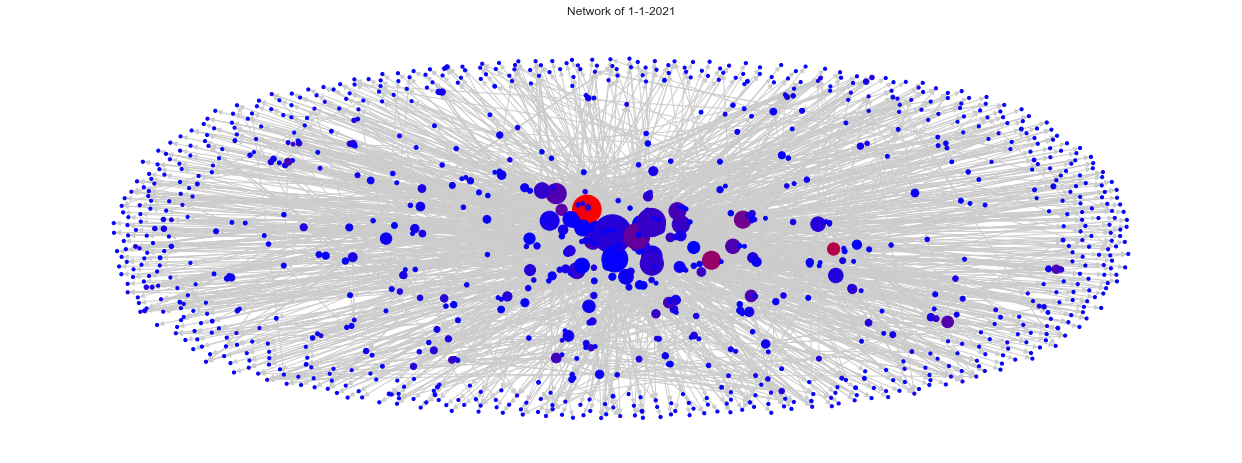

In [88]:
plt.figure(figsize=(22,8))
g = nx.read_gpickle(make_path(drive_path, size, subreddit, query, after_date='31-12-2020', before_date='2-1-2021') + 'Network.pickle')
d_in = dict(g.in_degree()); max_in = max(d_in.values())
d_out = dict(g.out_degree())
plt.title('Network of 1-1-2021')
nx.draw(g, edge_color=(0.8,0.8,0.8), nodelist=list(d_in.keys()), node_size=[v*5+10 for v in d_out.values()], node_color=[(v/max_in,0, 1 -v/max_in) for v in d_in.values()])
print('Node size increases with out-degree\nNode color ranges from blue (low) to red (high) in-degree')

The intuition of scale-free networks can be formally verified by inspecting the degree distribution on a log-log histogram. Contrary to random network in which high degree nodes are much less common, a scale-free network has relatively many high-degree nodes (compare chapter 4 of the network science book). Its histogram should approximate a triangle which (due to its constant slope) appears to be the same, regardless of how far one zooms in. The social network explored here has the below histograms for in-degree, out-degree and betweenness centrality aggragated over the three months of weekly samples. Although the histograms are not perfectly triangular they match a scale-free network closer that a random network. Regarding the betweenness-centrality on can further observe that there are a few individual with large and 1 with extraordinarily large centraltiy. Hence, these individuals are on the shortest path connecting a large number of pairs of other nodes. One can thus conclude that the social structure in the wallstreet bets subreddit community concerned with the GME stock has a hierarchical structure in which there are a few highly influential actors, some medium influential actors and a large majority of actors who resonate with the leaders.

<Figure size 1440x360 with 0 Axes>

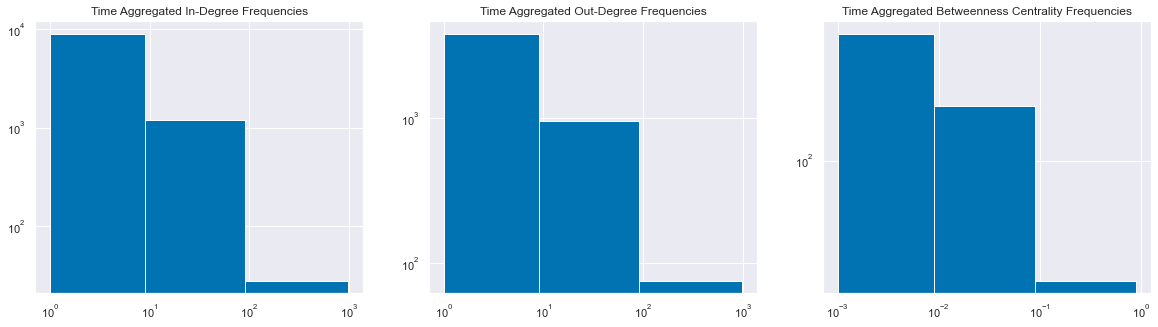

In [89]:
# These before_dates are for a three month simulation with 1-day-per-week samples
before_dates = ['14-11-2020','21-11-2020','28-11-2020','5-12-2020','12-12-2020','19-12-2020','26-12-2020','2-1-2021','9-1-2021','16-1-2021','23-1-2021','30-1-2021','6-2-2021']#,'13-2-2021']

in_degrees, out_degrees, betweenness_centralities, action_counts = [], [] ,[], [None] * len(before_dates)

plt.figure(figsize=(20,5)); 
for b, before_date in enumerate(before_dates):
  g, action_counts[b] = load_attributed_graph(before_date=before_date, data_folder=drive_path) 
  in_degrees += dict(g.in_degree).values(); out_degrees += dict(g.out_degree).values(); betweenness_centralities += dict(nx.betweenness_centrality(nx.DiGraph(g))).values()

plt.figure(figsize=(20,5)); 
plt.subplot(1,3,1); plt.title('Time Aggregated In-Degree Frequencies')
plt.hist(in_degrees, bins=[1,9,90,990]); plt.yscale('log'); plt.xscale('log')
plt.subplot(1,3,2); plt.title('Time Aggregated Out-Degree Frequencies')
plt.hist(out_degrees, bins=[1,9,90,990]); plt.yscale('log'); plt.xscale('log')
plt.subplot(1,3,3); plt.title('Time Aggregated Betweenness Centrality Frequencies')
plt.hist(betweenness_centralities, bins=[0.001,0.009,0.09,0.9]); plt.yscale('log'); plt.xscale('log')

The next step of the exploratory network analysis focused on the sentiment that actors elicited in their posts. The sentiment was classified using the natural language tool kit. In line with the goal to use Diao et al.'s model for opinion dynamics the below diagram shows the proportion of actors whose sentiment appeared supportive, neutral or opposing with regard to the GME stock discussions. One can see that a positive sentiment is elicited in around half of the posts while neutral or negative sentiment each occupy roughly a quarter of posts. This distribution remains reasonably stable across time. Overall, the number of posts in discussions peek during the christmas holiday break.

                                                             Action frequencies
O: opposing actors
N: neutral actors
S: supporting actors


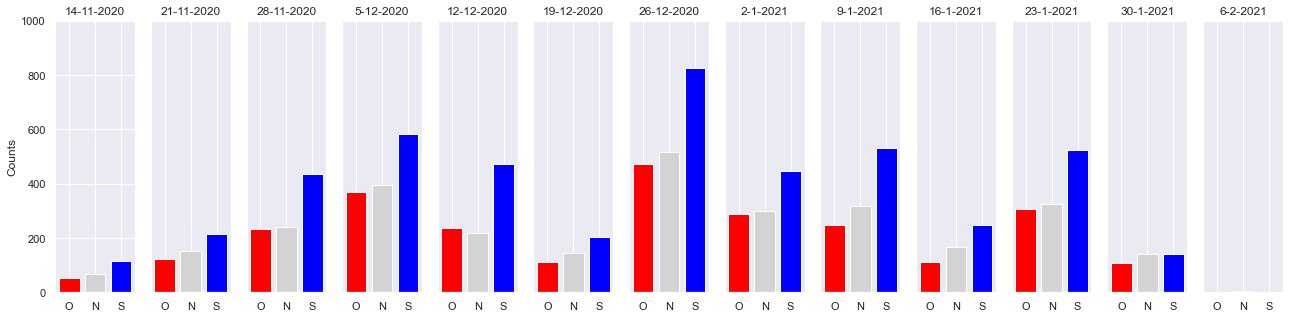

In [90]:
plt.figure(figsize=(22,5))
for b, before_date in enumerate(before_dates):
  plt.subplot(1, len(before_dates), b+1); plt.title(before_date)
  dic = {'opposing':'O','supporting':'S','neutral':'N'}
  plt.bar([dic[k] for k in action_counts[b].keys()], action_counts[b].values(),color=['red','lightgray','blue']);  plt.ylim((0,1000)); 
  if b == 0: plt.ylabel('Counts')
  else:
    ax = plt.gca(); ax.set_yticks([])
print('                                                             Action frequencies')
print('O: opposing actors\nN: neutral actors\nS: supporting actors')

In [91]:
def predict(drive_path, run_count, before_dates, min_degree_for_tabu, use_target):
  '''Predict the evolution of actions in the social network.
  Inputs:
    drive_path: str
    run_count: int specifying how many runs the model should perform to obtain confidence intervals aroung its estimates.
    before_dates: [int] listing dates of the form d-m-yyyy that reference the files in the data directory.
    min_degree_for_tabu: int indicating the minimum degree a user needs to have in order to be excldued from the list of persuaders when a person's action is predicted for the next time frame.
    use_target: bool indicating whether a target individual should persuade itself.'''
  all_runs_true_supporters = [None]*run_count; all_runs_true_opponents = [None]*run_count; all_runs_true_neutrals = [None]*run_count; 
  all_runs_false_supporters = [None]*run_count; all_runs_false_opponents = [None]*run_count; all_runs_false_neutrals = [None]*run_count

  baseline_all_runs_true_supporters = [None]*run_count; baseline_all_runs_true_opponents = [None]*run_count; baseline_all_runs_true_neutrals = [None]*run_count; 
  baseline_all_runs_false_supporters = [None]*run_count; baseline_all_runs_false_opponents = [None]*run_count; baseline_all_runs_false_neutrals = [None]*run_count


  for r in range(run_count):
    # Initialze previous social graph
    previous_graph, previous_action_counts = load_attributed_graph(before_date=before_dates[0], data_folder=drive_path)
    previous_odds = {}

    for individual_name in previous_graph.nodes.keys(): previous_odds = update_previous_odds(previous_odds=previous_odds, previous_graph=previous_graph, individual_name=individual_name, use_target=use_target)

    # Initialize classification records
    true_supporters = []; true_opponents = []; true_neutrals = []; false_supporters = []; false_opponents = []; false_neutrals = []
    baseline_true_supporters = []; baseline_true_opponents = []; baseline_true_neutrals = []; baseline_false_supporters = []; baseline_false_opponents = []; baseline_false_neutrals = []
    supporting_counts = [previous_action_counts['supporting']]
    neutral_counts = [previous_action_counts['neutral']]
    opposing_counts = [previous_action_counts['opposing']]

    # Iterate the time points and predict the behaviours

    for before_date in before_dates[1:]:
      # Initialize current classification record
      for counter in [true_supporters, true_opponents, false_supporters, false_opponents, true_neutrals, false_neutrals, baseline_true_supporters, baseline_true_opponents, baseline_false_supporters, baseline_false_opponents, baseline_true_neutrals, baseline_false_neutrals]: counter.append(0)

      # Given the current graph predict the action of each individual
      current_graph, current_action_counts = load_attributed_graph(before_date=before_date, data_folder=drive_path)
      for individual_name in current_graph.nodes.keys():
        eta = 0.5 # controls the width of the region of odds_support that is counted as neutral
        lambda_ = 3.0 # controls the effect of social circles (people preferring to talk to like-minded people)
        # Take into account the clique of the current user
        # Person used to be neutral
        N_p_o = (int)(10 * opposing_counts[-1] / (supporting_counts[-1] + opposing_counts[-1]))
        N_p_s = (int)(10 * supporting_counts[-1] / (supporting_counts[-1] + opposing_counts[-1])) 
        
        if not individual_name in previous_odds.keys():
          previous_odds[individual_name] = 0.5 # Person starts out as neutral
        if np.log(2.0*previous_odds[individual_name]) > eta: # Person used to be a supporter
          N_p_o = (int)(10 * opposing_counts[-1] / (lambda_ * supporting_counts[-1] + opposing_counts[-1]))
          N_p_s = (int)(10 * lambda_ * supporting_counts[-1] / (lambda_ * supporting_counts[-1] + opposing_counts[-1])) 
        elif np.log(2.0*previous_odds[individual_name]) < -eta : # Person used to be an opponent
          N_p_o = (int)(10 * lambda_ * opposing_counts[-1] / (supporting_counts[-1] + lambda_ * opposing_counts[-1]))
          N_p_s = (int)(10 * supporting_counts[-1] / (supporting_counts[-1] + lambda_ * opposing_counts[-1])) 
        
        # Predict user action
        SI_supporting, SI_opposing = compute_received_social_influence(g=previous_graph, N_p_o=N_p_o, N_p_s=N_p_s, individual_i_name=individual_name, min_degree_for_tabu=min_degree_for_tabu, use_target=use_target)
        predicted_odds_supporting = update_odd_A(odd_A_n=previous_odds[individual_name], SI_A_n=SI_supporting, SI_B_n=SI_opposing)
        
        
        # Update previous action record
        previous_odds[individual_name] = predicted_odds_supporting
        
        # Update odds for the next iteration
        previous_odds = update_previous_odds(previous_odds=previous_odds, previous_graph=current_graph, individual_name=individual_name, use_target=use_target)
        
        if eta < np.log(2.0*predicted_odds_supporting):   predicted_action = 'supporting' 
        elif np.log(2.0*predicted_odds_supporting) < -eta: predicted_action = 'opposing'
        else: predicted_action = 'neutral'
        
        # Update records of prediction performance
        actual_action = current_graph.nodes[individual_name]['action']
        true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals = update_class_counts(actual_action, predicted_action, true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals)
        baseline_true_supporters, baseline_true_opponents, baseline_true_neutrals, baseline_false_supporters, baseline_false_opponents, baseline_false_neutrals = update_class_counts(actual_action, rd.choice(['neutral','supporting','opposing']), baseline_true_supporters, baseline_true_opponents, baseline_true_neutrals, baseline_false_supporters, baseline_false_opponents, baseline_false_neutrals)

      supporting_counts.append(current_action_counts['supporting']); neutral_counts.append(current_action_counts['neutral']); opposing_counts.append(current_action_counts['opposing'])
      
      # Propagate graph
      previous_graph = current_graph; previous_action_counts = current_action_counts

    # Save results of current run
    all_runs_true_supporters[r] = np.mean(true_supporters); all_runs_true_opponents[r] = np.mean(true_opponents); all_runs_true_neutrals[r] = np.mean(true_neutrals)
    all_runs_false_supporters[r] = np.mean(false_supporters); all_runs_false_opponents[r] = np.mean(false_opponents); all_runs_false_neutrals[r] = np.mean(false_neutrals)
    
    baseline_all_runs_true_supporters[r] = np.mean(baseline_true_supporters); baseline_all_runs_true_opponents[r] = np.mean(baseline_true_opponents); baseline_all_runs_true_neutrals[r] = np.mean(baseline_true_neutrals)
    baseline_all_runs_false_supporters[r] = np.mean(baseline_false_supporters); baseline_all_runs_false_opponents[r] = np.mean(baseline_false_opponents); baseline_all_runs_false_neutrals[r] = np.mean(baseline_false_neutrals)
    
  # Visualize results
  plt.figure(figsize=(30,10))
  plt.subplot(1,3,1); plt.title('Supporting Actors')
  y_error = 3*np.std([[np.mean(supporting_counts)]*run_count, baseline_all_runs_true_supporters, baseline_all_runs_false_supporters], axis=-1)
  plt.errorbar(['Actual','True','False'], np.mean([[np.mean(supporting_counts)]*run_count, baseline_all_runs_true_supporters, baseline_all_runs_false_supporters], axis=-1),yerr=y_error); plt.ylim((0,800))
  y_error = 3*np.std([[np.mean(supporting_counts)]*run_count, all_runs_true_supporters, all_runs_false_supporters], axis=-1)
  plt.bar(['Actual','True','False'], np.mean([[np.mean(supporting_counts)]*run_count, all_runs_true_supporters, all_runs_false_supporters], axis=-1),yerr=y_error,color='lightgray'); plt.ylim((0,800))
  plt.legend(['Random Model','Social Model'])
  plt.ylabel('Count')

  plt.subplot(1,3,2); plt.title('Opposing Actors')
  y_error = 3*np.std([[np.mean(opposing_counts)]*run_count, baseline_all_runs_true_opponents, baseline_all_runs_false_opponents], axis=-1)
  plt.errorbar(['Actual','True','False'], np.mean([[np.mean(opposing_counts)]*run_count, baseline_all_runs_true_opponents, baseline_all_runs_false_opponents], axis=-1), yerr=y_error); plt.ylim((0,800))
  y_error = 3*np.std([[np.mean(opposing_counts)]*run_count, all_runs_true_opponents, all_runs_false_opponents], axis=-1)
  plt.bar(['Actual','True','False'], np.mean([[np.mean(opposing_counts)]*run_count, all_runs_true_opponents, all_runs_false_opponents], axis=-1), yerr=y_error, color='lightgray'); plt.ylim((0,800))
  plt.legend(['Random Model','Social Model'])
  plt.ylabel('Count')

  plt.subplot(1,3,3); plt.title('Neutral Actors')
  y_error = 3*np.std([[np.mean(neutral_counts)]*run_count, baseline_all_runs_true_neutrals, baseline_all_runs_false_neutrals], axis=-1)
  plt.errorbar(['Actual','True','False'], np.mean([[np.mean(neutral_counts)]*run_count, baseline_all_runs_true_neutrals, baseline_all_runs_false_neutrals], axis=-1), yerr=y_error); plt.ylim((0,800))
  y_error = 3*np.std([[np.mean(neutral_counts)]*run_count, all_runs_true_neutrals, all_runs_false_neutrals], axis=-1)
  plt.bar(['Actual','True','False'], np.mean([[np.mean(neutral_counts)]*run_count, all_runs_true_neutrals, all_runs_false_neutrals], axis=-1), yerr=y_error,color='lightgray'); plt.ylim((0,800))
  plt.legend(['Random Model','Social Model'])
  plt.ylabel('Count')

The second research question asked about the effect of the most popular users on the wallstreetsbets subreddit community when it comes to discussions on GME. The model by Diao et al. was used to predict a person's sentiment towards the topic based on their latent opinion. Latent opinion $Odds_S$ was modelled by taking into account the person's previous $Odds_S$ as well as the person's neighbors. The below diagram shows the predicted proportions of people with supporting, neutral and opposing verbal behaviour (sentiment). Each of the three subplots show the actual number of users in this category, the true positives and the false negatives. The gray bars indicate the performance of the model while the blue lines indicate the performance of a random model that merely guesses each person's subsequent verbal action. Error bars are obtained by repeating the analysis $r=10$ times. One can see that the model significantly outperforms the random model. It increases the ratio of true over false predictions for supporting, neutral as well as opposing actors. In order to test whether popular users actually have an effect on the community the analysis was repeated by adding all users with a degree above 100 to a taboo list. Hence, they could not be used by the model to estimate the supporting or opposing social influence on a target individual. It was expected that the model would performs less well in this case. 

Model performance


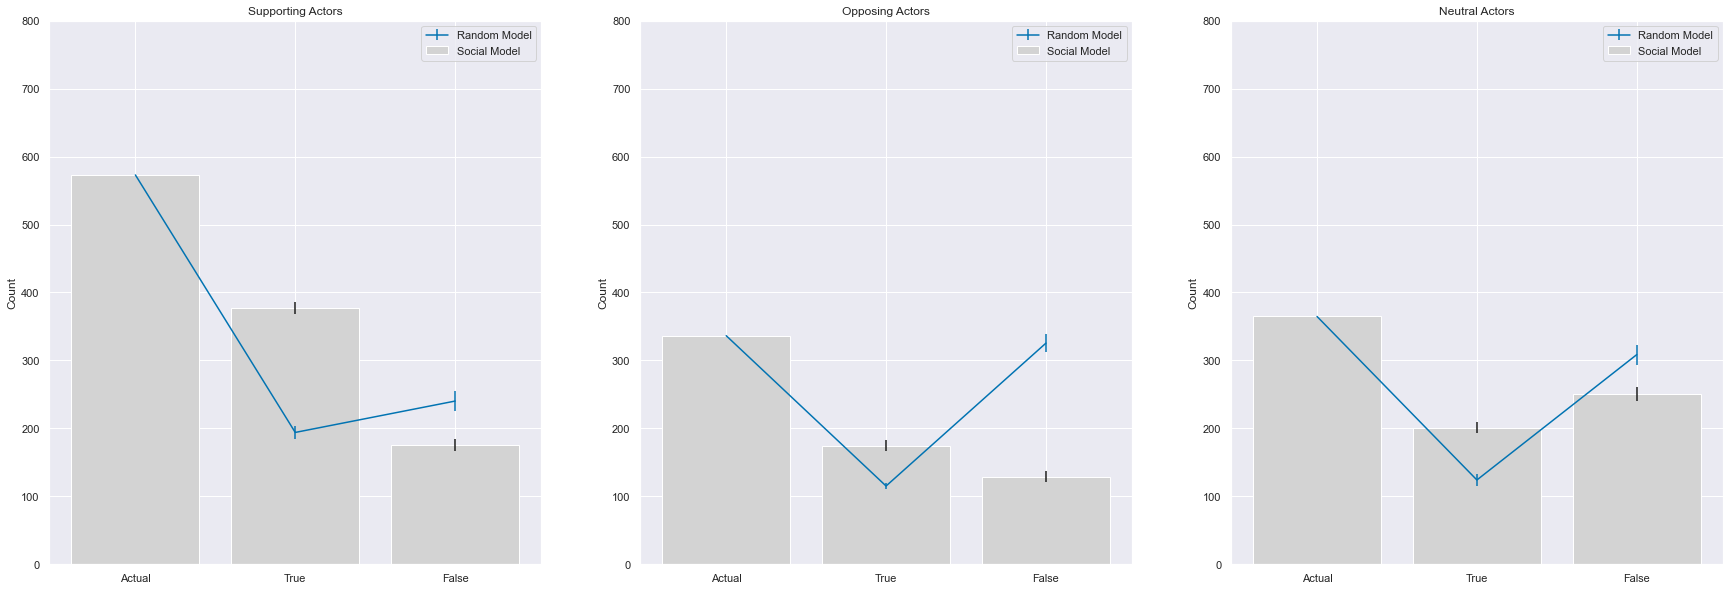

In [92]:
# These before_dates are for a 1 week simulation with daily samples
before_dates = ['20-12-2020', '21-12-2020', '22-12-2020', '23-12-2020', '24-12-2020', '25-12-2020', '26-12-2020']

# Run the model without adding nodes to the tabu list
predict(drive_path=drive_path, run_count=10, before_dates=before_dates, min_degree_for_tabu=10^9, use_target=True)
print('Model performance')

The below diagram shows the results for the configuration in which popular users were added to the taboo list. One can see that the model still outperforms the random model in that its ratio for true over false predictions are increased for supporters, neutrals and opponents. This finding is surprising and challenges the ratioanle that popular users are responsible for spreading sentiment towards the GME stock price among the wallstreetbets community. An alternative mechansism governing sentiment in the network be the so-called confirmation bias (https://en.wikipedia.org/wiki/Confirmation_bias). This bias described by social osychologists as the tendency to search for information confirming one's existing beliefs. In order to test whether a person's verbal action at day $t$ would predict their action at day $t+1$ the analysis was repeated by preventing a person from persuading itself.

Model performance with tabu list containing users with degree above 100


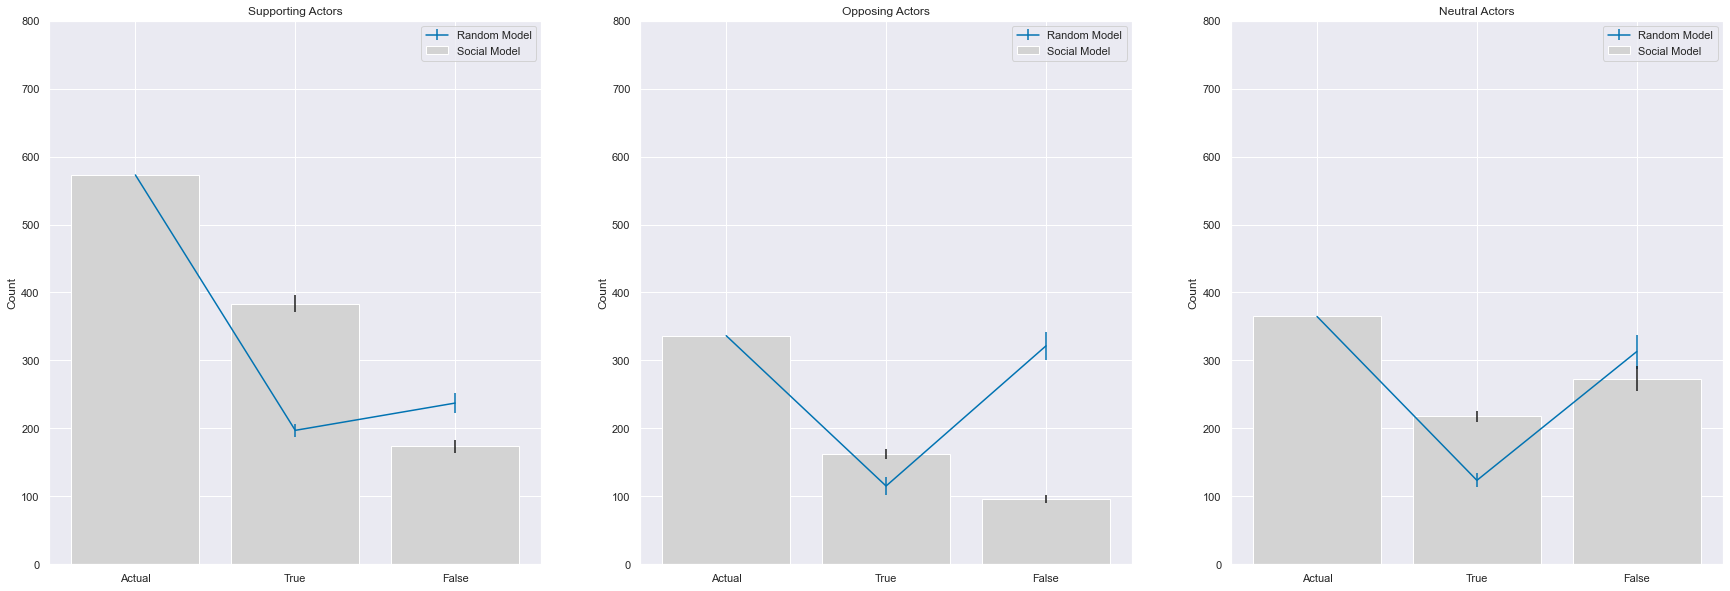

In [93]:
# Run the model without adding nodes to the tabu list
predict(drive_path=drive_path, run_count=10, before_dates=before_dates, min_degree_for_tabu=10^2, use_target=True)
print('Model performance with tabu list containing users with degree above 100')

The below diagram shows how the model's performance deteriorates when a person is not allowed to persuade itself. One can see immediately than it predicts most people to be neutral. Consequently, there are less predictions for supporting or opposing verbal actions. This finding suggests that popular players in the community are unlikely to change a person's opinion fast, i.e. within one day. Instead, it appears that people maintain their pre-existing beliefs.

Model performance without self-persuasion


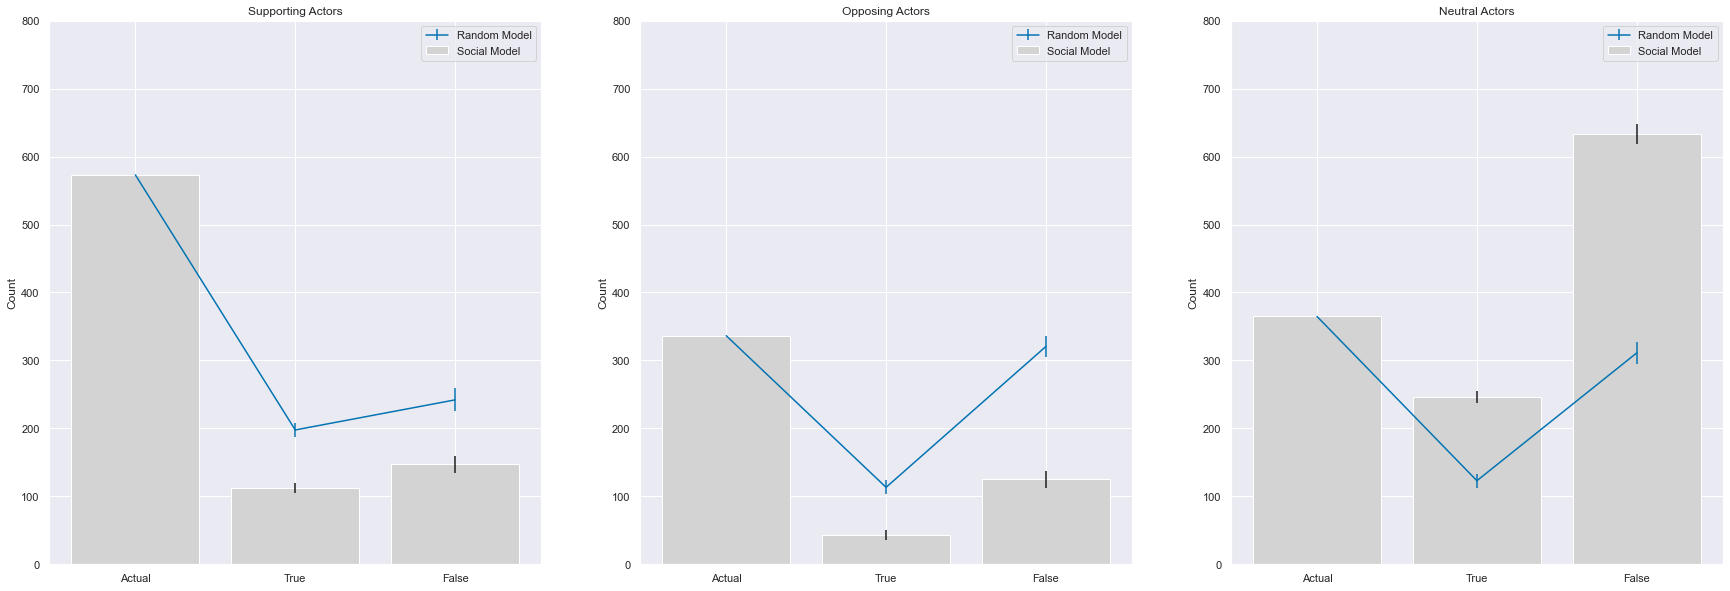

In [97]:
# Run the model without adding nodes to the tabu list
predict(drive_path=drive_path, run_count=10, before_dates=before_dates, min_degree_for_tabu=10^9, use_target=False)
print('Model performance without self-persuasion')

# Discussion
The second research question asked on the impact of popular users on the sentiment (verbal action) of the remaining wallstreetsbets subreddit community when it comes to discussion on the GME stock price. It used the opinion dynamics model proposed by Diao et al. to predict a person's opinion at day $t+1$ based on their opinion at day $t$ as well as the persuasive influence of its neighbors. As the social network was found to have a scale-free degree distribution its social structure can be described as hierarchical. It was thus expeced that sentiment of popular actors would spread among the crowds. The analyssi revealed that the model outperformed a random model regardless of whether popular users were allowed to persuade others or not. This unexpected finding was put into perspective when the model was configured to ignore a person's opinion at day $t$. In this case the model predicted an overwhelming majority of people to elicit neutral verbal behaviour. This manipulation revealed that a person's opinion is more likely to be affected by itself and less likely to be changed by others, regardless of their popularity. One has to note that the model only considered a person's opinion from the previous day. At this point one might aim to study the dynamics of a person's longterm development. Possibly, the rate of change in a person's ratio of posts with positive to negative sentiment is an even more reliable indicator than their latent opinion at day $t$.

# Question 3: Which other stocks are receiving increased attention within the wallstreetbets community?

To answer this question, data was pulled from the PushShiftAPI.

In [94]:
#api = PushshiftAPI()
#start=int(datetime.datetime(2021, 2, 10).timestamp())
#end=int(datetime.datetime(2021, 2, 28).timestamp())

#api_request_generator = api.search_submissions(subreddit='wallstreetbets', after=start, before=end)

In [95]:
#wsb_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

In [96]:
#wsb_submissions.to_csv("posts_retrieved_from_api.csv")

Additionally, data was also pulled using PRAW, a wrapper for the Reddit API.

In [133]:
#reddit=praw.Reddit(
#    client_id='<client id here>',
#    client_secret='<client secret here',
#    user_agent='<user agent name here>',
#)
#df_subid=pd.read_csv('submission_ids_DD.csv')
#first_sub=df_subid.columns[0]
#submission=reddit.submission(first_sub)
#starting=False
#subid=[]
#body=[]
#id=[]
#link_id=[]
#parent_id=[]
#subreddit=[]
#utc=[]
#i=0
#while i <df_subid.shape[0]:
#    if starting:
#        sub=df_subid.iat[i,0]
#        submission = reddit.submission(sub)
#        submission.comments.replace_more(limit=0)
#        for top_level_comment in submission.comments:
#            subid.append(sub)
#            body.append(top_level_comment.body)
#            id.append(top_level_comment.id)
#            link_id.append(top_level_comment.link_id)
#            parent_id.append(top_level_comment.parent_id)
#            subreddit.append(top_level_comment.subreddit)
#            utc.append(top_level_comment.created_utc)
#        i=i+1
#        print(i)
#    else:
#        starting=True
#        submission.comments.replace_more(limit=0)
#        for top_level_comment in submission.comments:
#            subid.append(first_sub)
#            body.append(top_level_comment.body)
#            id.append(top_level_comment.id)
#            link_id.append(top_level_comment.link_id)
#            parent_id.append(top_level_comment.parent_id)
#            subreddit.append(top_level_comment.subreddit)
#            utc.append(top_level_comment.created_utc)

#print(len(utc))
#data=np.empty([len(utc),7],dtype=object)
#data[:,0]=subid
#data[:,1]=body
#data[:,2]=id
#data[:,3]=link_id
#data[:,4]=parent_id
#data[:,5]=subreddit
#data[:,6]=utc
#df_popularSub=pd.DataFrame(data,columns=['sub_id','body','id','link_id','parent_id','subreddit','utc'])
#df_popularSub.to_csv('DDsubmissions.csv')




In [98]:
wsb_submissions = pd.read_csv("posts_retrieved_from_api.csv")

/Users/trevinalitchmore/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (4,68,80,81,82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [99]:
wsb_submissions['date'] = pd.to_datetime(wsb_submissions['created_utc'], utc=True, unit='s')

In [100]:
#Tags in WSB
wsb_submissions["link_flair_text"].unique()

array(['Meme', 'Discussion', 'Loss', 'News', 'YOLO', 'Chart', 'Gain',
       'DD', nan, 'Earnings Thread', 'Shitpost', 'Weekend Discussion',
       'Daily Discussion', 'Mods', 'OC'], dtype=object)

In [101]:
DDdata = wsb_submissions[wsb_submissions["link_flair_text"] == "DD"][["id", "title"]]
YOLOdata = wsb_submissions[wsb_submissions["link_flair_text"] == "YOLO"][["id", "title"]]

In [103]:
tickers = pd.read_csv("tickers.csv")

In [104]:
tickers_dict = dict()

for _ in range(len(tickers)):
    tickers_dict[tickers.iloc[_, 0]] = tickers.iloc[_, 1]

In [105]:
def remove_stopword(listt):
    return [word for word in listt if word.lower() not in stopwords.words('english')]

def clean(series):
    #Look for tickers and keep them caps, make the rest small
    #remove stopwords
    #remove punctuation marks
    #remove DD, Yolo, YOLO 
    s=[]
    
    for index, title in series.iteritems():
        
        #Remove punctuations
        title = re.sub(r'[^\w\s]', '', title) 
        
        #Tokenize
        title_into_words = title.split()
        
        #Remove stopwords
        title_wo_sw = remove_stopword(title_into_words)
        
        if "DD" in title_wo_sw:
            title_wo_sw.remove("DD")
        if "YOLO" in title_wo_sw:
            title_wo_sw.remove("YOLO")
        if "Yolo" in title_wo_sw:
            title_wo_sw.remove("Yolo")
        
        new_list = []
        
        for word in title_wo_sw:
            if word not in tickers_dict.keys():
                new_list.append(word.lower()) 
            else:
                new_list.append(word.upper())
                    
        #print(title_wo_sw)
        s.append(new_list)
        
    return s

In [106]:
DDdata["Tokenized"] = clean(DDdata["title"])
YOLOdata["Tokenized"] = clean(YOLOdata["title"])

In [107]:
DDdata[["title","Tokenized"]].head()

,title,Tokenized
23,Using Covered Calls to Buy Volatile Stocks lik...,"[using, covered, calls, buy, volatile, stocks,..."
93,Meme stock price target,"[meme, stock, price, target]"
116,Cryptography DD,[cryptography]
150,This is...,[]
165,I see a lot of memes about AMC and other stock...,"[see, lot, memes, AMC, stocks, GME]"


In [108]:
YOLOdata[["title","Tokenized"]].head()

,title,Tokenized
8,Hot wheels unleashed and the buying power of s...,"[hot, wheels, unleashed, buying, power, spoile..."
16,Stimulus,[stimulus]
24,If I make this shot all your stocks go green,"[make, shot, stocks, go, green]"
25,"GME Yolo ¯\_(ツ)_/¯ it ain’t much, but it’s hon...","[GME, _ツ_, aint, much, honest, work]"
48,"LWSB: Lucid Wall Street bets, all longs - Luci...","[lwsb, lucid, wall, street, bets, longs, lucid..."


In [109]:
def getCount(data):
    ticker_count = FreqDist()
    for listt in data.Tokenized:
        for word in listt:
            if word in tickers_dict.keys():
                ticker_count[word] += 1
    return ticker_count

In [110]:
def todf(ticker_count):
    df = pd.DataFrame.from_dict(ticker_count, orient='index')
    df.columns = ['Frequency']
    df.index.name = 'Ticker'
    df.sort_values(by="Frequency", ascending=False, inplace=True)
    df.reset_index(inplace=True)
    return df

In [111]:
DDdata_count = getCount(DDdata)
YOLOdata_count = getCount(YOLOdata)

In [112]:
DDdf = todf(DDdata_count)
YOLOdf = todf(YOLOdata_count)

In [113]:
DDdf.head(10) 

,Ticker,Frequency
0,GME,549
1,AMC,234
2,SNDL,168
3,SOS,99
4,PLTR,94
5,TLRY,81
6,RKT,58
7,EV,55
8,APHA,50
9,BB,46


In [114]:
[tickers_dict.get(ticker) for ticker in DDdf.Ticker.head(10) if ticker in tickers_dict.keys()]

['GameStop Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'SOS Limited American Depositary Shares',
 'Palantir Technologies Inc. Class A Common Stock',
 'Tilray Inc. Class 2 Common Stock',
 'Rocket Companies Inc. Class A Common Stock',
 'Eaton Vance Corporation Common Stock',
 'Aphria Inc. Common Shares',
 'BlackBerry Limited Common Stock']

In [115]:
YOLOdf.head(10)

,Ticker,Frequency
0,GME,1564
1,AMC,1196
2,SNDL,544
3,PLTR,269
4,TLRY,120
5,CCIV,112
6,NOK,98
7,GO,97
8,SOS,90
9,CTRM,83


In [116]:
[tickers_dict.get(ticker) for ticker in YOLOdf.Ticker.head(10) if ticker in tickers_dict.keys()]

['GameStop Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'Palantir Technologies Inc. Class A Common Stock',
 'Tilray Inc. Class 2 Common Stock',
 'Churchill Capital Corp IV Class A Common Stock',
 'Nokia Corporation Sponsored American Depositary Shares',
 'Grocery Outlet Holding Corp. Common Stock',
 'SOS Limited American Depositary Shares',
 'Castor Maritime Inc. Common Shares']

<AxesSubplot:xlabel='Frequency', ylabel='Ticker'>

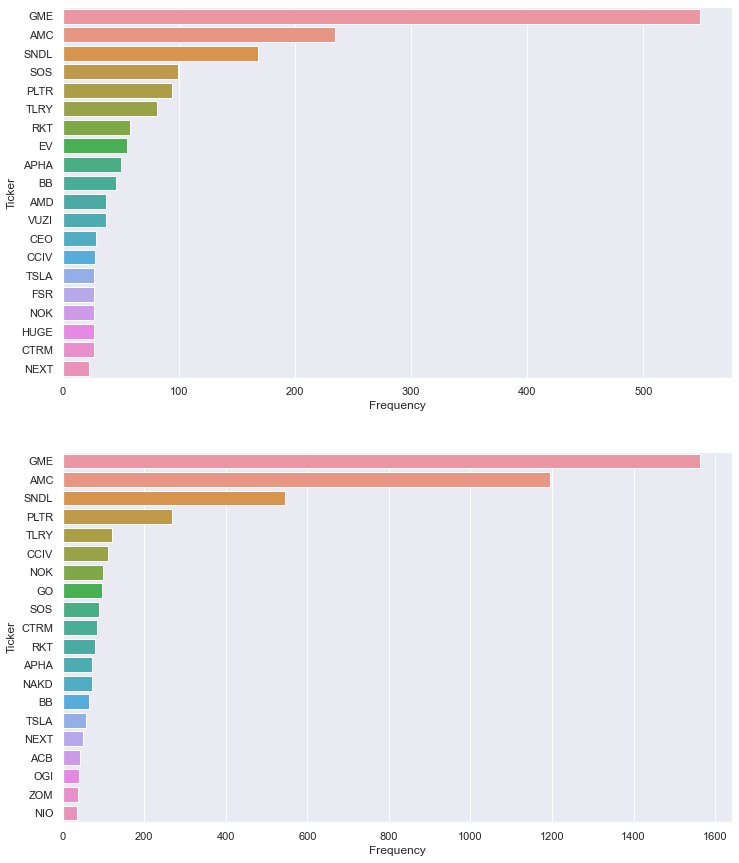

In [117]:
fig, ax = plt.subplots(2, figsize=(12,15))
sns.barplot(y='Ticker', x='Frequency', data=DDdf.head(20), ax=ax[0])
sns.barplot(y='Ticker', x='Frequency', data=YOLOdf.head(20), ax=ax[1])

## Sentiment towards top 10 tickers

In [118]:
def fetch_comments(submission_id):
    fields = ["body","id","link_id","parent_id"]
    allcomments = requests.get("https://api.pushshift.io/reddit/comment/search/?submission_id="+submission_id)
    if not allcomments.status_code==200:
        print('Unable to perform request with status code: ' + str(allcomments.status_code))
        return pd.DataFrame(columns=fields)
    else:
        comment_ids = getComment_id(allcomments)
        filtered_comments = requests.get("https://api.pushshift.io/reddit/comment/search?ids="+comment_ids+"&fields=body,id,link_id,parent_id"+"&size="+str(min(len(comment_ids),50)))
        #print("https://api.pushshift.io/reddit/comment/search?ids="+comment_ids+"&fields=body,id,link_id,parent_id")
        if not filtered_comments.status_code==200:
            print('Unable to perform request with status code: ' + str(filtered_comments.status_code))
            return pd.DataFrame(columns=fields)
        else: 
            return pd.DataFrame(json.loads(filtered_comments.text)["data"])

def getComment_id(result):
    s=""
    for dicti in json.loads(result.text)["data"]:
        s+=dicti.get("id")+","
    return s[:-1]

In [119]:
def comments_toSeries(data):
    return [fetch_comments(submission_id=data.iloc[i]['id']) for i in range(data.shape[0])]

In [120]:
commentsDD = pd.read_csv("DDsubmissions.csv")

In [121]:
commentsYOLO = pd.read_csv("YOLOsubmissions.csv")

In [122]:
commentsDD.drop(commentsDD.columns[0], axis=1, inplace=True)
commentsDD['date'] = pd.to_datetime(commentsDD['utc'], utc=True, unit='s')

commentsYOLO.drop(commentsYOLO.columns[0], axis=1, inplace=True)
commentsYOLO['date'] = pd.to_datetime(commentsYOLO['utc'], utc=True, unit='s')

In [123]:
commentsDD = commentsDD[commentsDD["date"]>=min(commentsDD["date"])]
commentsDD = commentsDD[commentsDD["date"]<=min(commentsDD["date"]) + datetime.timedelta(days=18)]

commentsYOLO = commentsYOLO[commentsYOLO["date"]>=min(commentsYOLO["date"])]
commentsYOLO = commentsYOLO[commentsYOLO["date"]<=min(commentsYOLO["date"]) + datetime.timedelta(days=18)]

In [124]:
commentsDD.shape, commentsYOLO.shape

((27840, 8), (27519, 8))

In [125]:
commentsDD["Tokenized"] = clean(commentsDD["body"])
commentsDD["Tokenized_joined"] = commentsDD["Tokenized"].apply(lambda x: ' '.join(x))

In [126]:
commentsYOLO["Tokenized"] = clean(commentsYOLO["body"])
commentsYOLO["Tokenized_joined"] = commentsYOLO["Tokenized"].apply(lambda x: ' '.join(x))

In [127]:
commentsDD.to_csv("cleanedDDcomments.csv")
commentsYOLO.to_csv("cleanedYOLOcomments.csv")

In [128]:
commentsDD.head(2)

,sub_id,body,id,link_id,parent_id,subreddit,utc,date,Tokenized,Tokenized_joined
0,ltzb4d,Another downside is that the stock plummets an...,gp3h2a6,t3_ltzb4d,t3_ltzb4d,wallstreetbets,1.614468e+09,2021-02-27 23:16:23+00:00,"[another, downside, stock, plummets, youre, le...",another downside stock plummets youre left hol...
1,ltzb4d,Exactly what I've wanted to do but don't have ...,gp3dj89,t3_ltzb4d,t3_ltzb4d,wallstreetbets,1.614467e+09,2021-02-27 22:55:21+00:00,"[exactly, ive, wanted, dont, bankroll, buy, 10...",exactly ive wanted dont bankroll buy 100 share...


In [129]:
commentsYOLO.head(2)

,sub_id,body,id,link_id,parent_id,subreddit,utc,date,Tokenized,Tokenized_joined
0,ltzb06,Wtf is this shit normie. Why slow down a video...,gp3dfmy,t3_ltzb06,t3_ltzb06,wallstreetbets,1.614466e+09,2021-02-27 22:54:46+00:00,"[wtf, shit, normie, slow, video, know, people,...",wtf shit normie slow video know people autism ...
1,ltzb06,🥶,gp3gdal,t3_ltzb06,t3_ltzb06,wallstreetbets,1.614468e+09,2021-02-27 23:11:46+00:00,[],


In [130]:
def getSentiments(series):
    sentiment_label=[]
    for comment in series:
        model = SentimentIntensityAnalyzer()
        sentiment = model.polarity_scores(comment)
        positive, neutral, negative = sentiment['pos'], sentiment['neu'], sentiment['neg']
        
        if comment=="":
            sentiment_label.append("neutral "+str(neutral))
        else:
            if max(positive,neutral,negative) == positive:
                sentiment_label.append("positive "+str(positive))
            elif max(positive,neutral,negative) == negative:
                sentiment_label.append("negative "+str(negative))
            else: 
                sentiment_label.append("neutral "+str(neutral))
        #print(comment," : ",sentiment_label)
        #print(len(sentiment_label),"/",len(series))
        
    return sentiment_label

In [131]:
def getTickerofthecomment(series):
    tickerincomment = []
    for comment in series:
        #print(comment)
        ticker_count = FreqDist()
        for word in comment:
            if word in tickers_dict.keys():
                ticker_count[word] += 1
        ticker_count = dict(ticker_count)
        if len(ticker_count)==0:
            tickerincomment.append(None)
        elif len(ticker_count)==1:
            tickerincomment.append(list(ticker_count.keys())[0])
        else:
            tickerincomment.append(max(ticker_count, key=ticker_count.get))
        #print(len(tickerincomment),"/",len(series))
    return tickerincomment

In [132]:
commentsDD["comment_sentiment"] = getSentiments(commentsDD["Tokenized_joined"])

In [134]:
commentsDD["comment_ticker"] = getTickerofthecomment(commentsDD["Tokenized"])

In [135]:
commentsYOLO["comment_sentiment"] = getSentiments(commentsYOLO["Tokenized_joined"])

In [136]:
commentsYOLO["comment_ticker"] = getTickerofthecomment(commentsYOLO["Tokenized"])

In [137]:
commentsYOLO = pd.read_csv("YOLOcomments_Sentiments_beforescore.csv")
commentsDD = pd.read_csv("DDcomments_Sentiments_beforescore.csv")

In [138]:
commentsDD.drop(commentsDD.columns[[0,13]], axis=1, inplace=True)

In [139]:
commentsYOLO[['comment_sentiment','sentiment_score']] = commentsYOLO['comment_sentiment'].str.split(' ', expand=True)

In [140]:
commentsDD[['comment_sentiment','sentiment_score']] = commentsDD['comment_sentiment'].str.split(' ', expand=True)

In [141]:
commentsDD[["body","Tokenized","comment_sentiment", "comment_ticker", "sentiment_score"]].head(2)

,body,Tokenized,comment_sentiment,comment_ticker,sentiment_score
0,Another downside is that the stock plummets an...,"['another', 'downside', 'stock', 'plummets', '...",neutral,GME,0.807
1,Exactly what I've wanted to do but don't have ...,"['exactly', 'ive', 'wanted', 'dont', 'bankroll...",neutral,NaN,0.635


In [142]:
commentsYOLO[["body","Tokenized","comment_sentiment", "comment_ticker", "sentiment_score"]].tail(2)

,body,Tokenized,comment_sentiment,comment_ticker,sentiment_score
27517,"The YOLO flair exists for the highest stakes, ...","['flair', 'exists', 'highest', 'stakes', 'high...",neutral,NaN,0.606
27518,"The YOLO flair exists for the highest stakes, ...","['flair', 'exists', 'highest', 'stakes', 'high...",neutral,NaN,0.606


In [143]:
commentsYOLO.to_csv("YOLOcomments_Sentiments_beforescore.csv")
commentsDD.to_csv("DDcomments_Sentiments_beforescore.csv")

In [144]:
commentsYOLO["sentiment_score"] = commentsYOLO["sentiment_score"].astype(float)
commentsDD["sentiment_score"] = commentsDD["sentiment_score"].astype(float)

In [145]:
def sentAnalysis(data, ddf):
    sentiments_perticker = dict()
    for popticker in ddf.head(10)["Ticker"]:
        pos = 0
        neg = 0
        neu = 0
        df = data[data["comment_ticker"]==popticker]
        total = len(df)
        for senti,score in zip(df["comment_sentiment"],df["sentiment_score"]):
            if senti=="positive":
                pos+=score
            if senti=="negative":
                neg+=score
            if senti=="neutral":
                neu+=score
        sentiments_perticker[popticker] = [(pos/total),(neg/total),(neu/total)]
    return sentiments_perticker

In [146]:
DDsentiments_perticker = pd.DataFrame(sentAnalysis(commentsDD, DDdf), index=["Positive", "Negative", "Neutral"]).transpose()

In [147]:
YOLOsentiments_perticker = pd.DataFrame(sentAnalysis(commentsYOLO, YOLOdf), index=["Positive", "Negative", "Neutral"]).transpose()

In [148]:
YOLOsentiments_perticker

,Positive,Negative,Neutral
GME,0.028113,0.020966,0.689117
AMC,0.043607,0.012442,0.748236
SNDL,0.032900,0.013600,0.752833
PLTR,0.042967,0.011577,0.698893
TLRY,0.000000,0.000000,0.842923
CCIV,0.085333,0.000000,0.572000
NOK,0.071235,0.030265,0.732735
GO,0.019714,0.019357,0.828143
SOS,0.051250,0.000000,0.764417
CTRM,0.000000,0.000000,1.000000


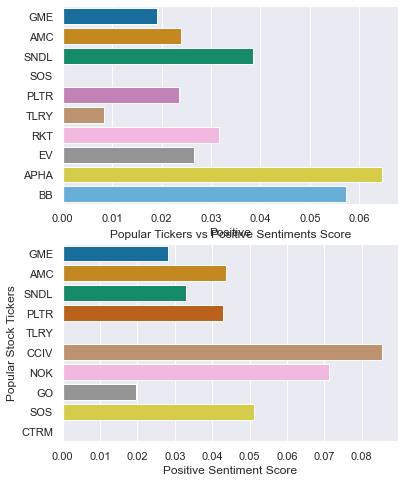

In [149]:
fig, ax = plt.subplots(2, figsize=(6,8))
sns.barplot(y=DDsentiments_perticker.index, x='Positive', data=DDsentiments_perticker, ax=ax[0])
sns.barplot(y=YOLOsentiments_perticker.index, x='Positive', data=YOLOsentiments_perticker, ax=ax[1])

plt.title('Popular Tickers vs Positive Sentiments Score')
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Popular Stock Tickers')
plt.show()